## Chapter 13: Multi-layer Perceptrons 

# 13.1 Multi-layer perceptrons (MLPs)

Unlike polynomials and other fixed kernel bases, each element of a neural network basis has internal parameters that can be tuned to give it a flexible shape. In this Section we detail multi-layer neural networks - often called *multi-layer perceptrons* or *deep feedforward neural networks*. We begin by describing deep networks in the context of our previous discussion, as a particular catalog of nonlinear functions used for nonlinear learning problems. We then turn to describe these network elements from a computational perspective, so that we can more easily see how to effectively compute with them.

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import autograd.numpy as np
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import math_optimization_library as optlib
basic_runner = nonlib.basic_runner
regress_plotter = nonlib.nonlinear_regression_demos
classif_plotter = nonlib.nonlinear_classification_demos
static_plotter = optlib.static_plotter.Visualizer()
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import basic plotting mechanisms
import matplotlib.pyplot as plt
from matplotlib import gridspec

# This is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# autoreload function - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

## 13.1.1 Single-layer basis functions

At the heart of nonlinear learning is the following simple yet powerful idea: nonlinear curves of arbitrary shape can be expressed/approximated via a linear combination of simpler nonlinear functions of the input data that are organized in a way to form a basis. With neural networks each of these basis functions is also parameterized with a number of weights to be tuned using data. Here we discuss in detail how to form neural network basis functions starting with the simplest of them: a single-layer function.  

### Recursive rescipe for single layer perceptron units

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> Activation function $a\left(\cdot\right)$<br>

<strong>2:</strong>&nbsp;&nbsp; Compute linear combination of input:  $w_{0}+{\sum_{n=1}^{N}}{w_{n}\,x_n}$ <br>

<strong>3:</strong>&nbsp;&nbsp; Pass result through nonlinear activation: $f^{(1)}\left(\mathbf{x}\right) = a\left(w_{0}+{\sum_{n=1}^{N}}{w_{n}\,x_n}\right)$ <br>

<strong>5:</strong>&nbsp;&nbsp; <strong>output:</strong> Single layer perceptron unit $f^{(1)}$<br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

Notice how the resulting basis function, i.e., $a\left(w_{0}+{\sum_{n=1}^{N}}{w_{n}\,x_n}\right)$, is both  *parameterized* (via the internal weights $w_0,\ldots,w_N$ introduced in the first step), and *nonlinear*, because of the nonlinear function $a$ used in the second step, usually referred to as the *activation* function. In the next Subsection we discuss the origin of neural networks' nomenclature from a historical perspective.      

#### <span style="color:#a50e3e;">Example 1. </span> The shape of single-layer functions with $\text{tanh}$ activation 

In the Python cell below we plot four instances of a single-layer basis function using $\text{tanh}$ as nonlinear activation function. These take the form 

\begin{equation}
f^{(1)}(x) = \text{tanh}\left(w_0 + w_1x\right)
\end{equation}

The input here is one-dimensional (scalar) to facilitate visualization of the basis functions. In each instance the internal parameters have been set randomly, giving each basis function a distinct shape.

<IPython.core.display.Javascript object>


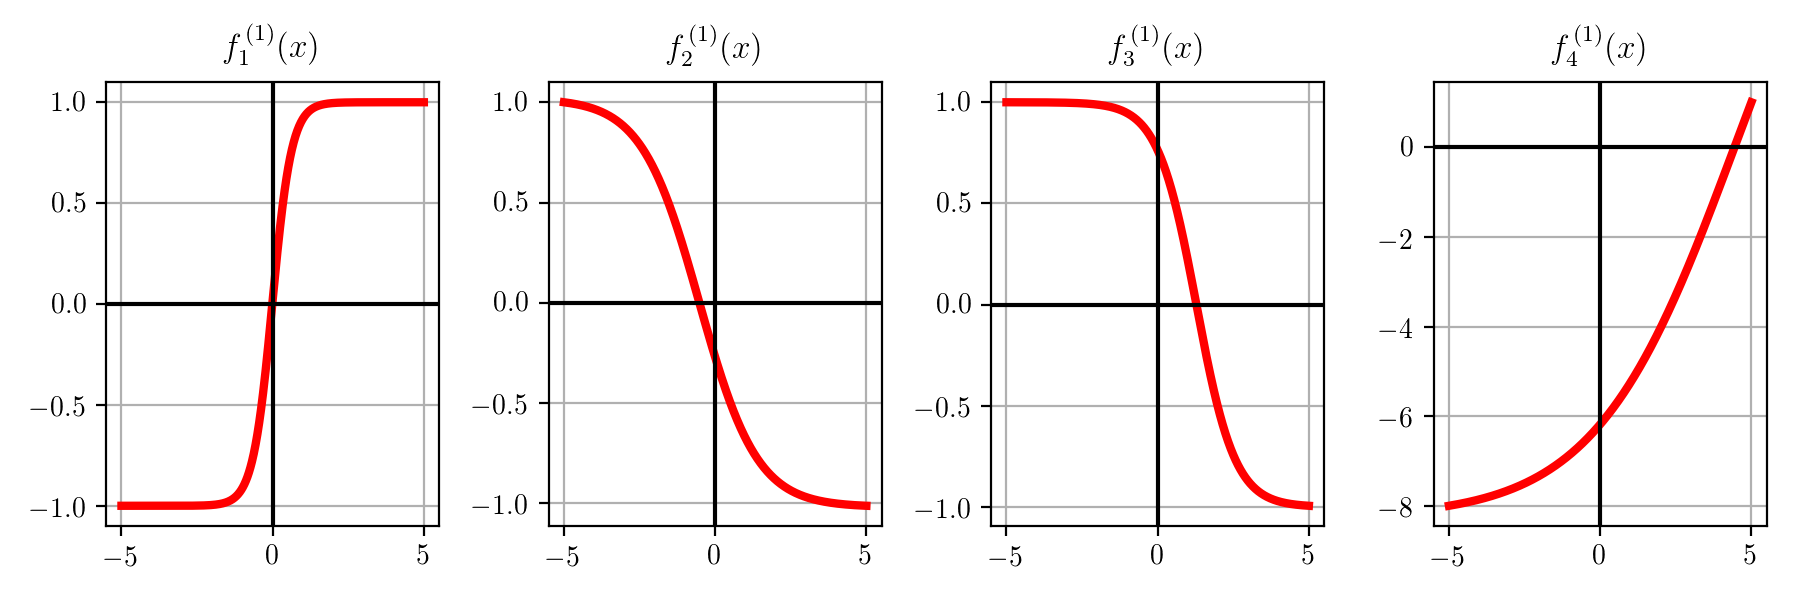

In [2]:
# import Draw_Bases class for visualizing various basis element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of a single layer basis
demo.show_1d_net(num_layers = 1, activation = 'tanh')

<hr>

#### <span style="color:#a50e3e;">Example 2. </span> The shape of single-layer functions with ReLU activation 

We repeat the experiment in Example 1, this time swapping $\text{tanh}$ for ReLU as activation, i.e., they take the form

\begin{equation}
f^{(1)}(x) = \text{max}\left(0,w_0 + w_1x\right)
\end{equation}

<IPython.core.display.Javascript object>


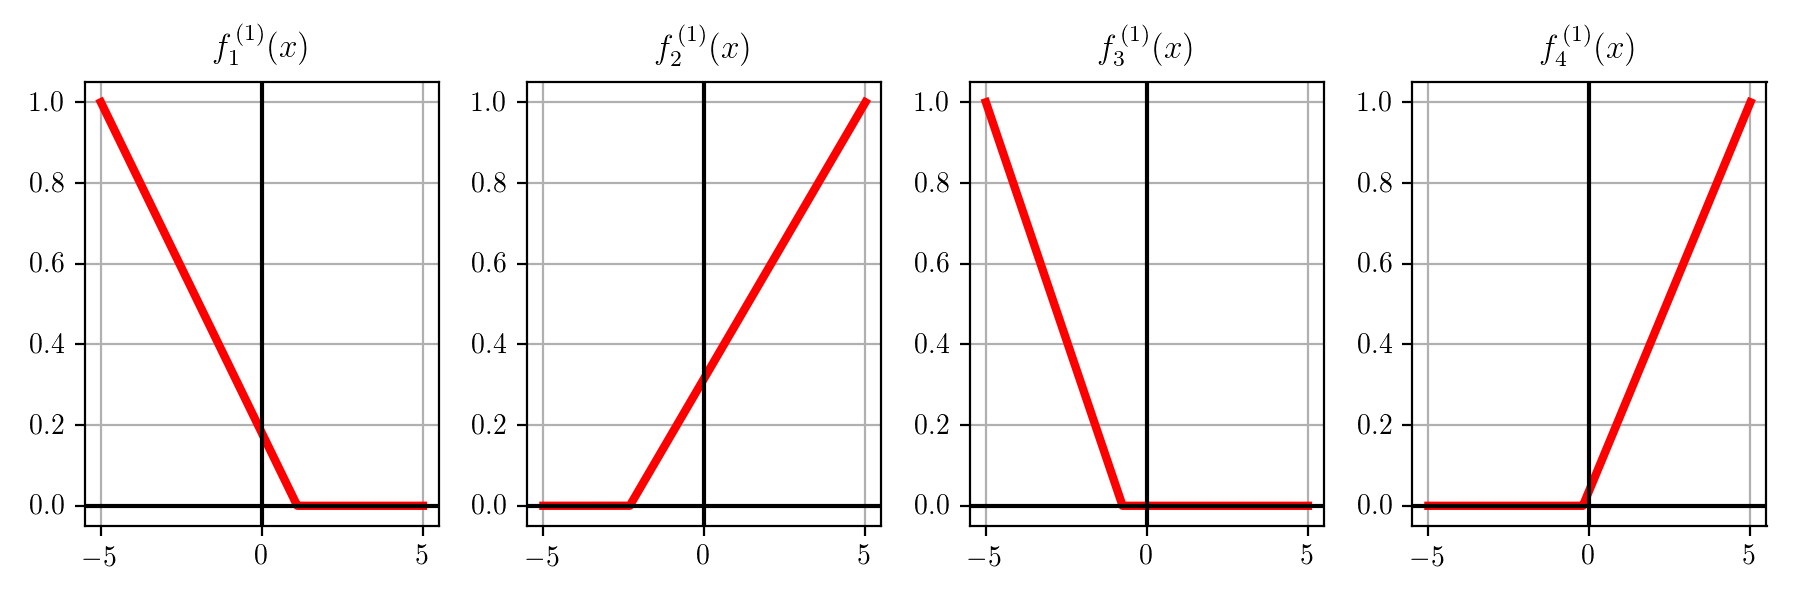

In [3]:
# import Draw_Bases class for visualizing various basis element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of a single hidden layer basis
demo.show_1d_net(num_layers = 1, activation = 'relu')

### Graphical representation of single layer basis functions

Ever since Hippocrates argued, over two thousand years ago, that the brain was "the seat of the mind," scientists have been studying it with the hope of unlocking the secrets of human intelligence. In fact the field we know today as Artificial Intelligence (AI) was born in an ambitious quest to mathematically model the complex human brain. The first attempts were made in the 1940s [[1,2]](#bib_cell) by a group of psychologists and neuroscientists who proposed simplistic mathematical models for a single neuron (brain cell). These early models - later dubbed as artificial neurons - culminated in the introduction of the *perceptron* model [[3]](#bib_cell) in 1957.

Figure 1 shows a comparative illustration of a biological neuron (left) and a *perceptron* (right). The biological neuron consists of three main parts: *dendrites* (the neuron's receivers), *soma* (the cell body), and *axon* (the neuron's transmitter). Closely mimicking this structure, an artificial neuron comprises a set of dendrite-like edges, each taking an input and multiplying it by a (synaptic) weight associated with that edge. These weighted inputs are summed up after going through a *summation unit* (shown in the figure by a small hollow circle). The result is subsequently fed to an *activation unit* (shown by a large blue circle) whose output is then transmitted to the outside via an axon-like projection. Notice how the output of the perceptron model takes the same form as a single-layer basis function derived in Subsection 1.1.1. The graphical model shown in the right panel of Figure 1 is therefore commonly used to visually represent a single-layer neural network basis function.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/bio_v_art.png" width="100%" height="auto"/>
<figcaption> <strong>Figure 1:</strong> <em> (left) A typical biological neuron. (right) An artificial neuron (perceptron). A perceptron is a simplistic mathematical model for the biological neuron consisting of: (i) weighted edges that represent the individual multiplications (of $1$ by $w_{0}$, $x_1$ by $w_{1}$, etc.), (ii) a summation unit shown as a small hollow circle representing the sum $w_0+w_{1}\, x_1+\cdots+w_{N}\, x_N$, and (iii) an activation unit shown as a larger blue circle representing the sum evaluated by the nonlinear activation function $a$. </em>
</figcaption>
</figure>

From a biological perspective, neurons are believed to remain inactive until the net input to the cell body (soma) reaches a certain threshold, at which point the neuron gets *activated* and fires an electro-chemical signal, hence the name *activation function*.

### Algebraic representation of single layer basis functions

The algebraic representation of a single-layer basis function is quite simple. In fact we have already seen it in the previous Subsections:

\begin{equation}
f^{(1)}_j\left(x_1,x_2,\ldots,x_N\right)=a\left(w^{\left(1\right)}_{0,\,j}+\underset{n=1}{\overset{N}{\sum}}{w^{\left(1\right)}_{n,\,j}\,x_n}\right)
\end{equation}

Because each single-layer element has *tunable internal parameters* it can take on a variety of shapes as we now explore through the following examples.

## 13.1.2 Two-layer basis functions

That single-layer basis functions we discussed in the previous Section have tunable internal parameters, gives them a range of possible shapes to take as saw in Examples 1 and 2. However, the flexibility of each basis function is limited to some extent. In Example 1 all we can control is the horizontal placement of the function (via $w_{0}$) and the steepness of the transition from $-1$ to $1$ (via $w_{1}$). Similarly in Example 2, we can only move the ReLU in the horizontal direction and change the slope of its forearm. 

One question immediately arises: can we boost the flexibility (or expressive power) of a single-layer basis? The answer is a resounding yes, all we need to do is re-use the recipe in Subsection 1.1.1, with a slight modification.

### Recursive rescipe for two layer perceptron units

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> Activation function $a\left(\cdot\right)$, number of single layer units $U_1$<br>

<strong>2:</strong>&nbsp;&nbsp;  Construct single layer units $f^{(1)}_j\left(\mathbf{x}\right)$ for $j=1,\,...,U_1$ <br>

<strong>3:</strong>&nbsp;&nbsp; Compute linear combination of single layer units: $w_{0}+{\sum_{j=1}^{U_1}}{w_{j}\,f^{(1)}_j}\left(\mathbf{x}\right)$  <br>


<strong>5:</strong>&nbsp;&nbsp; Pass result through nonlinear activation: $f^{(2)}\left(\mathbf{x}\right) = a\left(w_{0}+{\sum_{j=1}^{U_1}}{w_{j}\,f^{(1)}_j}\left(\mathbf{x}\right)\right)$   <br>

<strong>6:</strong>&nbsp;&nbsp; <strong>output:</strong> Two layer perceptron unit $f^{(2)}$<br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

What changed here? We have just replaced the input $x_1,x_2,\ldots,x_N$ with the single-layer basis functions $f^{(1)}_1,f^{(1)}_2,\ldots,f^{(1)}_{U_1}$. The superscripts on $f_j$'s indicate they are *single-layer* functions.

#### <span style="color:#a50e3e;">Example 3. </span> The shape of two-layer functions with $\text{tanh}$ activation

We plot four instances of a two-layer basis function using $\text{tanh}$ as activation, akin to what we did in Example 1. All weights are again set randomly in each instance.  These look like

\begin{equation}
f^{(2)}(x) = \text{tanh}\left(w_2 + w_3\,f^{(1)}(x)\right)
\end{equation}

where

\begin{equation}
f^{(1)}(x) =  \text{tanh}\left(w_0 + w_1x\right)
\end{equation}

<IPython.core.display.Javascript object>


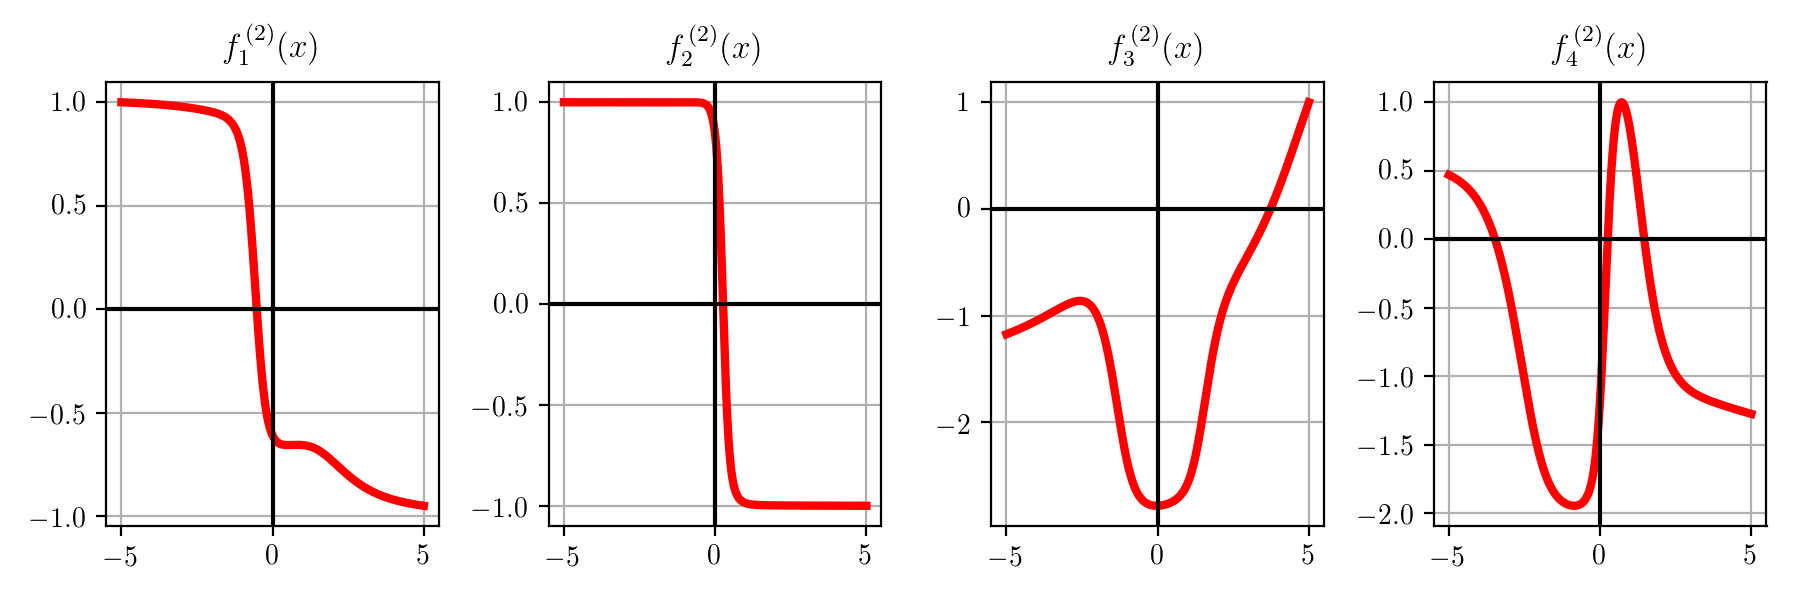

In [23]:
# import Draw_Bases class for visualizing various basis element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of the polynomial basis
demo.show_1d_net(num_layers = 2, activation = 'tanh')

### Graphical representation of two layer basis functions

Is it possible to visually represent a two-layer basis function as we did with a single-layer function in the right panel of Figure 1? The answer is yes, considering that we already have a way of graphically representing a single-layer function *and*  a recipe to create two-layer functions from single-layer ones. According to our recipe we first need $U_1$ single-layer functions. These are stacked column-wise in the left panel pf Figure 2, the first one of which is encompassed in a gray bubble for better visualization. Following our recipe we take a linear combination of these units and pass it through another activation to get a second-layer basis function, as depicted in the left panel of Figure 2.

Note the use of superscripts and subscripts in the form of $w^{(k)}_{i,j}$ to distinguish between the tunable weights. As before the superscript $k$ indicate the layer each weight belongs to. Interpreting this whole model as a graph with nodes and edges, the first subscript $i$ is then the node its corresponding edge originates from, and the second subscript $j$ is the node it ends up at. The bias weights have $i=0$.    

In the right panel of Figure 2 we show a more compact representation of the two-layer element on the left. Here we show the input nodes $1,x_1,\ldots,x_N$ only once, instead of duplicating them $U_1$ times, which results in a more condensed but equivalent representation. Because in this case there is not enough space left to write the first layer weights adjacent to their corresponding edges, we store them in an $\left(N+1\right)\times U_1$ matrix $\mathbf{W}_1$, shown symbolically via an orange square placed underneath the first layer edges.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/two_layer_elements.png" width="100%" height="auto"/>
<figcaption> <strong>Figure 2:</strong> <em> Graphical representation of a two-layer neural network basis function. (left) A two-layer element is constructed by cascading a series of $U_1$ perceptron units, and connecting their outputs to another perceptron unit in the second layer. (right) A more compact representation of the two-layer element on the left. See the text for more description. </em>
</figcaption>
</figure>

### Algebraic representation of two layer basis functions

Using the notational convention described in Subsection 1.2.2 and shown in Figure 2, we can write the algebraic form of a two-layer basis function $f_j^{\left(2\right)}\left(x_1,x_2,\ldots,x_N\right)$ as  

\begin{equation}
f_j^{\left(2\right)}\left(x_1,x_2,\ldots,x_N\right)=a\left(w^{\left(2\right)}_{0,j}+\underset{i=1}{\overset{U_1}{\sum}}{w^{\left(2\right)}_{i,j}}\,a\left(w^{\left(1\right)}_{0,i}+\underset{n=1}{\overset{N}{\sum}}{w^{\left(1\right)}_{n,i}\,x_n}\right)\right)
\end{equation}

That we are composing the nonlinear activation function with itself to create a two-layer basis function suggests that the latter can potentially be far more diverse in shape compared to its relatively simple single-layer counterpart. The example below verifies this. 

## 13.1.3 Three-layer basis functions 

Now that we have seen how to increase the flexibility of neural network bases by creating two-layer elements from single-layer ones, nothing keeps us from taking this idea one step further to create three-layer basis functions with even greater flexibility.  

### Recursive rescipe for three layer perceptron units

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> Activation function $a\left(\cdot\right)$, number of single and two layer units $U_1$ and $U_2$<br>

<strong>2:</strong>&nbsp;&nbsp; Construct two layer units $f^{(2)}_j\left(\mathbf{x}\right)$ for $j=1,\,...,U_2$ <br>

<strong>3:</strong>&nbsp;&nbsp; Compute linear combination of two layer units: $w_{0}+{\sum_{j=1}^{U_2}}{w_{j}\,f^{(2)}_j}\left(\mathbf{x}\right)$  <br>

<strong>4:</strong>&nbsp;&nbsp; Pass result through nonlinear activation: $f^{(3)}\left(\mathbf{x}\right) = a\left(w_{0}+{\sum_{j=1}^{U_2}}{w_{j}\,f^{(2)}_j}\left(\mathbf{x}\right)\right)$   <br>

<strong>6:</strong>&nbsp;&nbsp; <strong>output:</strong> Three layer perceptron unit $f^{(3)}$<br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

#### <span style="color:#a50e3e;">Example 4. </span> The shape of three-layer functions with $\text{tanh}$ activation 

In this Example we show four instances of a three-layer neural network basis function with $\text{tanh}$ activation. Once again, in each instance all weights are set randomly. Because each basis function here consists of a composition of three nonlinear functions, and because it has a great many parameters, these three-layer instances are considerably more flexible than the two-layer versions we saw previously in Example 3.

Each of these takes the algebraic form

\begin{equation}
f^{(3)}(x) = \text{tanh}\left(w_4 + w_5\,f^{(2)}(x)\right)
\end{equation}

where

\begin{array}
\
f^{(2)}(x) = \text{tanh}\left(w_2 + w_3\,f^{(1)}(x)\right) \\
f^{(1)}(x) =  \text{tanh}\left(w_0 + w_1x\right)
\end{array}

<IPython.core.display.Javascript object>


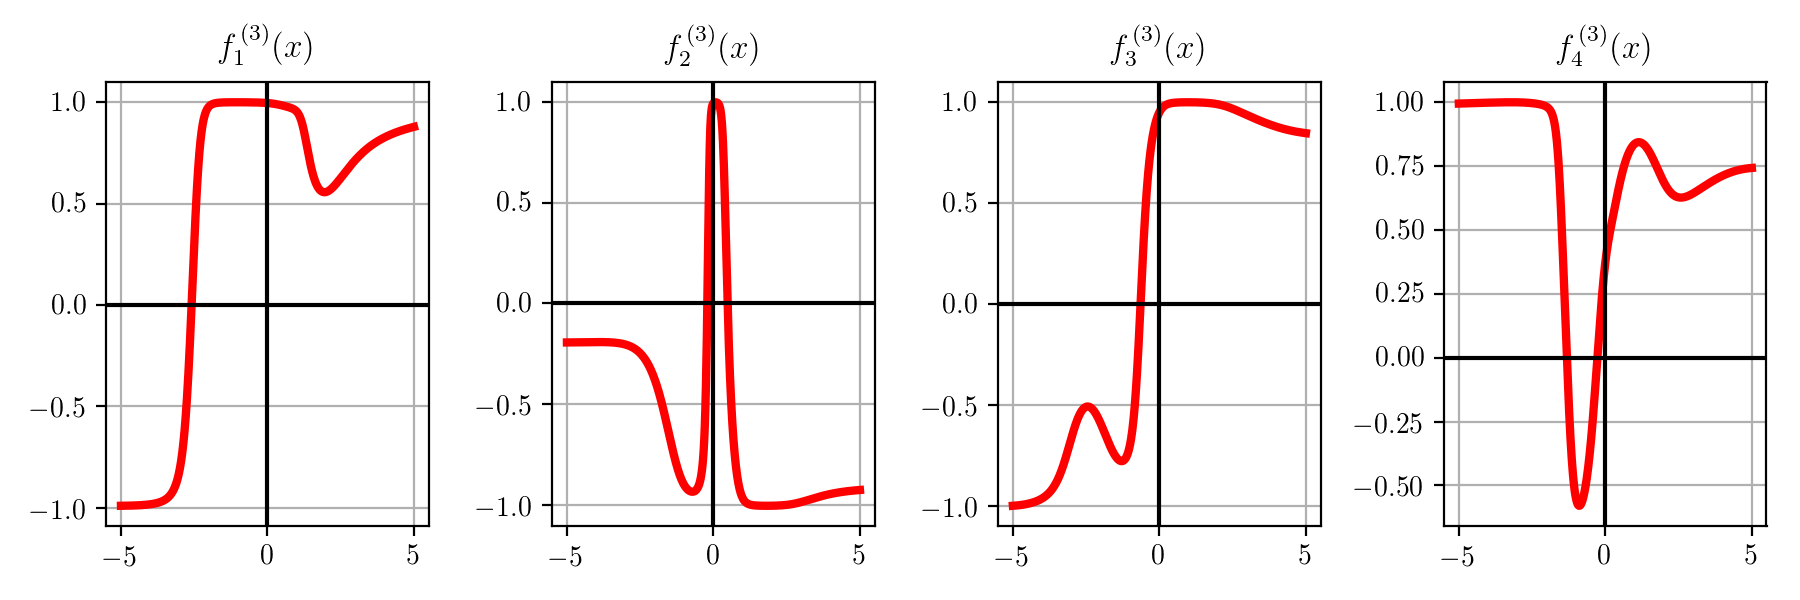

In [25]:
# import Draw_Bases class for visualizing various basis element types
demo = nonlib.DrawBases.Visualizer()

# plot the first 4 elements of the polynomial basis
demo.show_1d_net(num_layers = 3, activation = 'tanh')

### Graphical representation of three layer basis functions

According to our recipe, we can construct a three-layer basis function by cascading a series of two-layer basis functions, the first of which is shown inside a gray bubble in the left panel of Figure 3. Note that this is precisely the graphical representation of a two-layer element shown previously in the right panel of Figure 2. A three-layer basis function is then formed by connecting the outputs of these two-layer functions to another perceptron unit in the third layer. In the right panel of Figure 3 we show an equivalent but more compact representation of the three-layer graphical representation shown in the left panel, where the second layer weights are now stored in an $\left(U_1+1\right)\times U_2$ matrix $\mathbf{W}_2$ shown symbolically via an orange square placed underneath the second layer edges.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/three_layer_element.png" width="100%" height="auto"/>
<figcaption> <strong>Figure 3:</strong> <em> Graphical representation of a three-layer basis function. (left) A three-layer element is constructed by cascading a series of $U_2$ 2-layer elements (the first of which is encompassed in a gray bubble), and connecting their outputs to another perceptron unit in the third layer. (right) An equivalent but more condensed representation of the three-layer element on the left. See the text for more description. </em>
</figcaption>
</figure>

### Algebraic representation of three layer basis functions

One can write the explicit algebraic form of a three-layer neural network basis function by carefully following the graphical representation in Figure (3), as


\begin{equation}
f_j^{\left(3\right)}\left(x_1,x_2,\ldots,x_N\right)=a_{\,}\left(w^{\left(3\right)}_{0,j}+\underset{i=1}{\overset{U_2}{\sum}}{w^{\left(3\right)}_{i,j}}\,a_{\,}\left(w^{\left(2\right)}_{0,i}+\underset{k=1}{\overset{U_1}{\sum}}{w^{\left(2\right)}_{k,i}}\,a_{\,}\left(w^{\left(1\right)}_{0,k}+\underset{n=1}{\overset{N}{\sum}}w^{\left(1\right)}_{n,k}\,x_n\right)\right)\right)
\end{equation}

Currently the convention is to refer to neural network bases with elements having three or more layers as *deep* networks.

## 13.1.4 General multilayer basis functions

### Recursive rescipe for general $L$ layer perceptron units

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> Activation function $a\left(\cdot\right)$, desired number of units per layer $U_1,\,U_2,...,U_{L-1}$<br>

<strong>2:</strong>&nbsp;&nbsp; Construct $L-1$ layer units $f^{(L-1)}_j\left(\mathbf{x}\right)$ for $j=1,\,...,U_{L-1}$ <br>

<strong>3:</strong>&nbsp;&nbsp; Compute linear combination of $L-1$ layer units: $w_{0}+{\sum_{j=1}^{U_{L-1}}}{w_{j}\,f^{(L-1)}_j}\left(\mathbf{x}\right)$  <br>

<strong>4:</strong>&nbsp;&nbsp; Pass result through nonlinear activation: $f^{(L)}\left(\mathbf{x}\right) = a\left(w_{0}+{\sum_{j=1}^{U_{L-1}}}{w_{j}\,f^{(L-1)}_j}\left(\mathbf{x}\right)\right)$   <br>

<strong>5:</strong>&nbsp;&nbsp; <strong>output:</strong> $L$ layer perceptron unit $f^{(L)}$<br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

#### <span style="color:#a50e3e;">Example 5. </span> The shape of random autoencoder functions employing a 5 layer multilayer perceptron for both encoder and decoder 

In Section 12.3 we introduced the general nonlinear autoencoder, which consists of two (in general) nonlinear functions - an `encoder` $f_{\text{e}}$ and `decoder` $f_{\text{d}}$ - whose parameters we tune so that (ideally) the composition $f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}\right)\right)$ forms the best *nonlinear manifold* on which the input data sits.  That is, given a set of input points $\left\{\mathbf{x}_p\right\}_{p=1}^P$ we aim tune the parameters of our encoder / decoder pair so that ideally

\begin{equation}
f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}_p\right)\right) \approx \mathbf{x}_p
\end{equation}
 
for all of the datapoints.  Just as with a supervised learner we can use a multilayer perceptron here - and for both encoding and decoding functions - which in combination provides us with an enormous amount of flexibility in terms of the sort of nonlinear manifolds we can uncover.  

Below we plot out 9 random instances of an antoencoder function $f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}\right)\right)$ where we have used a 5 hidden layer multilayer perceptron with 10 units in each layer for both functions, and the function `sinc` as an activation.  In other words, below is plotted 9 instances of the function $f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}\right)\right)$ where both $f_{\text{d}}$ and $f_{\text{e}}$ are 5 layer networks with randomly chosen weights in each instance.  Each of examples shows the kind of nonlinear manifold we could potentially discover using such encoding/decoding functions.

<IPython.core.display.Javascript object>


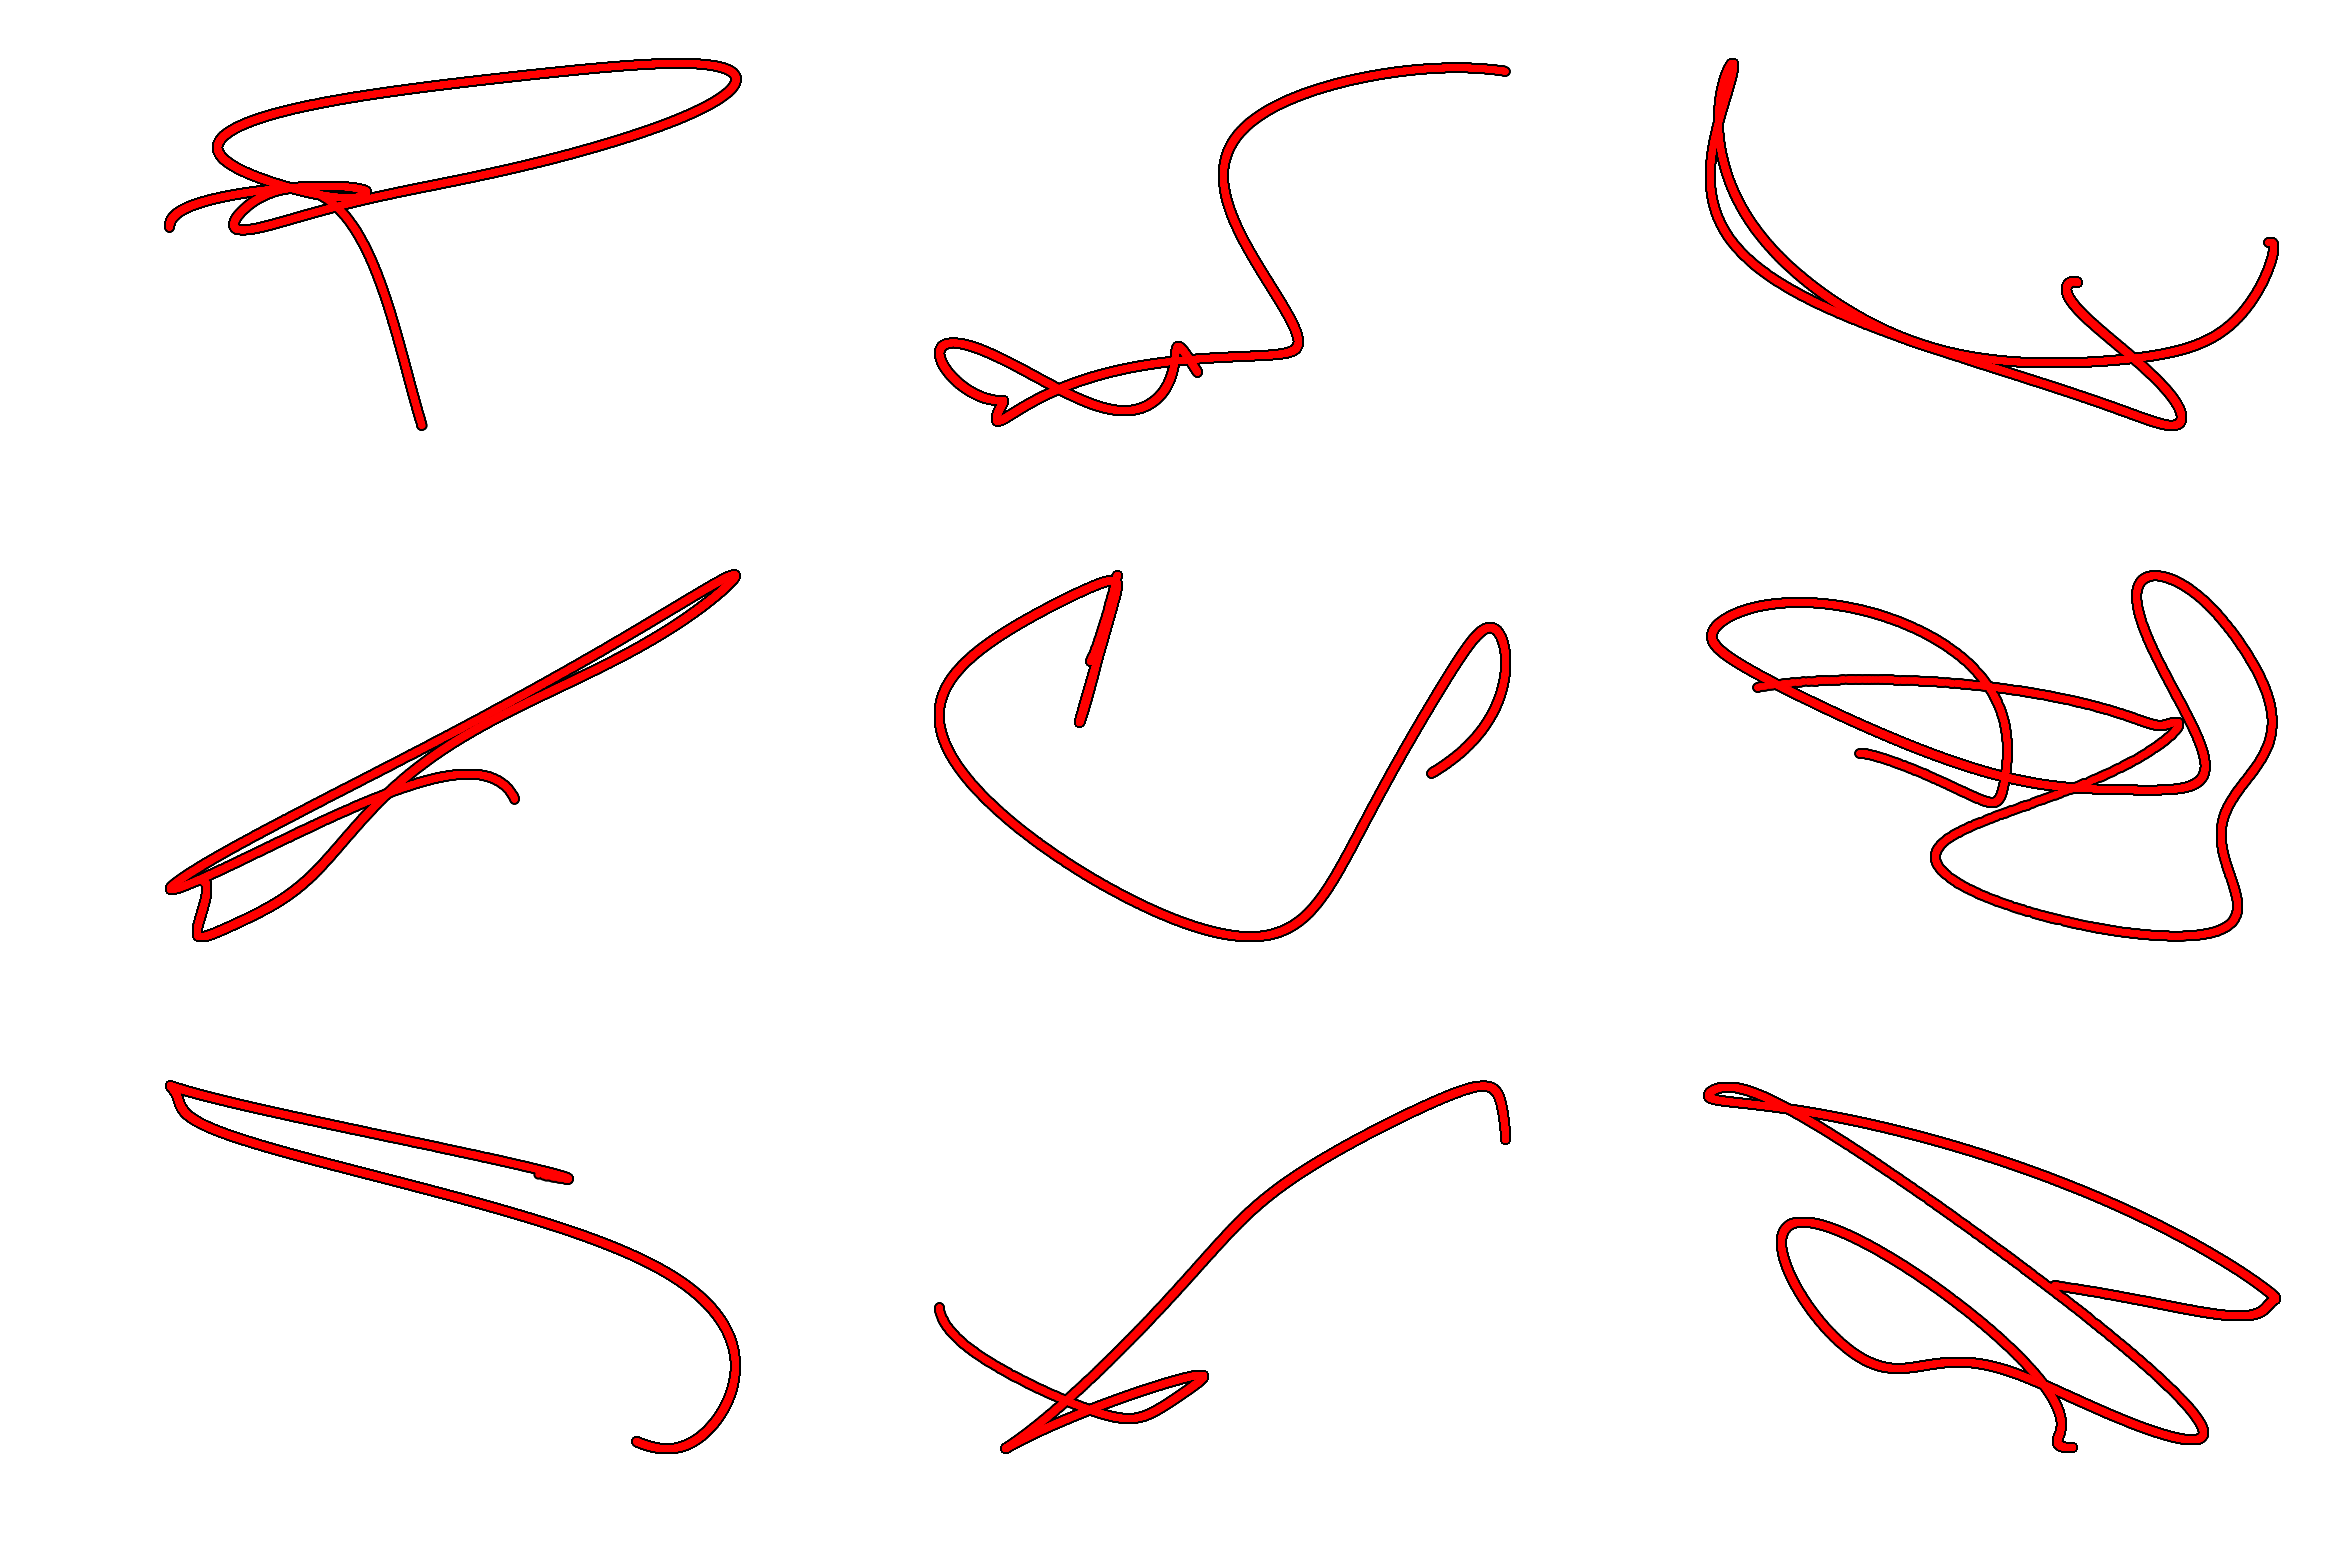

In [2]:
# show off 9 random autoencoders built using a 5 layer network for both
# encoder and decoder function and sinc as an activation function
demo = nonlib.squiggle_generator.Setup()
demo.make_so_many_squiggles()

### Graphical representation of multilayer basis functions

Generalizing the pattern we saw in the right panels of Figures 2 and 3, we show a condensed graphical representation of an $L$-layer neural network basis function in the top panel of Figure 4 wherein, as before, we have stored the internal weights of the $k^{th}$ layer in the matrix $\mathbf{W}_k$, defined for all $k=1,\ldots, L-1$ as

\begin{equation}
\mathbf{W}_{k}=\left[\begin{array}{cccc}
w_{0,1}^{\left(k\right)} & w_{0,2}^{\left(k\right)} & \cdots & w_{0,U_{k}}^{\left(k\right)}\\
w_{1,1}^{\left(k\right)} & w_{1,2}^{\left(k\right)} & \cdots & w_{1,U_{k}}^{\left(k\right)}\\
\vdots & \vdots & \ddots & \vdots\\
w_{U_{k-1},1}^{\left(k\right)} & w_{U_{k-1},2}^{\left(k\right)} & \cdots & w_{U_{k-1},U_{k}}^{\left(k\right)}
\end{array}\right]
\end{equation}  

Set $U_0=N$ to make (11) work when $k=1$.

<figure>
<img src="../../mlrefined_images/nonlinear_superlearn_images/L_layers.png" width="90%" height="auto"/>
<figcaption> <strong>Figure 4:</strong> <em> (top) Graphical representation of an $L$-layer neural network basis function. The $k^{th}$ layer weights are stored in the matrix $\mathbf{W}_k$ as defined in (5), for all $k=1,\ldots, L-1$. (bottom) Using equations (6-8) we can draw the computational graph of an $L$-layer basis function as a convenient replacement for the graphical representation shown in the top panel. As is our convention with computational graphs, we represent scalar, vector, and matrix variables with circles, diamonds, and squares, respectively. </em>
</figcaption>
</figure>

Graphical representation of deep neural network basis functions become exceedingly unwieldy as we increase the number of layers, or in other words, the *depth* of the network. This is especially an issue when begin thinking about coding up these networks. Employing computational graphs we can represent such basis functions much more compactly. 

Denote $\mathbf{x}$ as the $\left(N+1\right)\times 1$ input vector

\begin{equation}
\mathbf{x}=\left[\begin{array}{c}
1\\
x_{1}\\
\vdots\\
x_{N}
\end{array}\right]
\end{equation}

$\mathbf{a}$ as the vector function that takes in a general $d$-dimensional vector $\mathbf{v}$ and returns as output the $d+1$ dimensional vector 

\begin{equation}
\mathbf{a}\left(\mathbf{v}\right)=\left[\begin{array}{c}
1\\
a\left(v_{1}\right)\\
\vdots\\
a\left(v_{d}\right)
\end{array}\right]
\end{equation}

and $\mathbf{w}_{L,\,j}$ as the vector containing last layer's weights

\begin{equation}
\mathbf{w}_{L,\,j}=\left[\begin{array}{c}
w^{(L)}_{0,j}\\
w^{(L)}_{1,j}\\
\vdots\\
w^{(L)}_{U_{L-1},j}
\end{array}\right]
\end{equation}

With these three additional pieces, we can replace the bulky and redundant graphical model in the top panel of Figure 4 with the very compact computational graph shown in its bottom panel. In addition to compactness, the computational graph helps us better understand how computation flows in neural networks.  

### Algebraic representation of multilayer basis functions

As shown in Equation (4), the algebraic representation of a three-layer basis function is already too messy/complicated to be of any use. Thanks to the notational convention introduced in the previous Subsection that allowed us to draw the computational graph of a general $L$-layer function efficiently, we can use the same notation to write its algebraic equation as  

\begin{equation}
f_j^{\left(L\right)}\left(\mathbf{x}\right)=a\left(\mathbf{w}_{L,j}^T\,\mathbf{a}\,\left(\mathbf{W}_{L-1}^T\,\cdots\,\mathbf{a}\,\left(\mathbf{W}_{2}^T\,\mathbf{a}\left(\mathbf{W}_{1}^T\,\mathbf{x}\right)\right)\right)\right)
\end{equation}

## 13.1.5  Implementing multilayer perceptrons in `Python`

The recursive nature of a general $L$-layer neural network basis function - shown pictorially in the bottom panel of Figure 4 and algebraically in Equation (8) - allows for its compact and efficient implementation in ``Python``. Assuming we need $U_L$ of such basis functions or features to perform a supervised learning task, we can collect all of them in a single feature vector $\mathbf{f}$

\begin{equation}
\mathbf{f}=\left[\begin{array}{c}
f_1^{\left(L\right)}\left(\mathbf{x}\right)\\
f_2^{\left(L\right)}\left(\mathbf{x}\right)\\
\vdots\\
f_{U_L}^{\left(L\right)}\left(\mathbf{x}\right)
\end{array}\right]
\end{equation}


which, using (6), can be written in one line as  

\begin{equation}
\mathbf{f}=\mathbf{a}\left(\mathbf{W}_{L}^T\,\mathbf{a}\,\left(\mathbf{W}_{L-1}^T\,\cdots\,\mathbf{a}\,\left(\mathbf{W}_{2}^T\,\mathbf{a}\left(\mathbf{W}_{1}^T\,\mathbf{x}\right)\right)\right)\right)
\end{equation}

where $\mathbf{W}_L$, the matrix containing the weights of layer $L$, takes the form previously defined in (4).

The ``feature_transforms`` module below returns $\mathbf{f}$ as a function of $\mathbf{x}$: the input data, and $\mathbf{w}$: a tensor of weights $\mathbf{W}_1$ through $\mathbf{W}_L$.  

In [2]:
# choose a nonlinear activation function 
def activation(t):
    nonlinearity = np.tanh(t)
    return nonlinearity

# fully evaluate our network features using the tensor of weights in w
def feature_transforms(a, w):    
    # loop through each layer matrix
    for W in w:
        #  pad with ones (to compactly take care of bias) for next layer computation        
        o = np.ones((1,np.shape(a)[1]))
        a = np.vstack((o,a))
        
        # compute linear combination of current layer units
        a = np.dot(a.T, W).T
    
        # pass through activation
        a = activation(a)
    return a

Below we also provide a ``Python`` function ``initialize_network_weights`` that creates initial weights for a feedforward network, and also provides a simple interface for generating feedforward architectures with arbitrary numbers of layers.  To create a desired network you simply input a **comma-separated list** called ``layer_sizes`` into the function of the following form

\begin{equation}
\text{layer_sizes} = \begin{bmatrix}
N = \text{dimension of input }\mathbf{x} \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \\
U_1 = \text{number of desired units in layer 1} \\
U_2 = \text{number of desired units in layer 2} \\
\vdots \\
U_L = \text{number of desired units in layer L} \\
M = \text{dimension of output } y \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
\end{bmatrix}
\end{equation}

The initializer will then automatically create initial weight matrices (of the proper dimensions) $\mathbf{W}_1$ through $\mathbf{W}_L$ as well as the final weights for the linear combination in the prediction $\mathbf{w}$.  We will see explicit examples using this functionality - as well as the previous ``Python`` functions - in the examples below.

In [3]:
# create initial weights for arbitrary feedforward network
def initialize_network_weights(layer_sizes, scale):
    # container for entire weight tensor
    weights = []
    
    # loop over desired layer sizes and create appropriately sized initial 
    # weight matrix for each layer
    for k in range(len(layer_sizes)-1):
        # get layer sizes for current weight matrix
        U_k = layer_sizes[k]
        U_k_plus_1 = layer_sizes[k+1]

        # make weight matrix
        weight = scale*np.random.randn(U_k+1,U_k_plus_1)
        weights.append(weight)

    # re-express weights so that w_init[0] = omega_inner contains all 
    # internal weight matrices, and w_init = w contains weights of 
    # final linear combination in predict function
    w_init = [weights[:-1],weights[-1]]
    
    return w_init

## 13.1.6  Introductary examples using multilayer perceptrons

In this short subsection we employ the `Python` implementation shown above to solve a few elementary nonlinear supervised and unsupervised learning problems.  These simple examples help showcase the enormous amount of flexibility we can attain when using multilayer perceptrons as our feature transformations.

#### <span style="color:#a50e3e;">Example 6. </span>  Nonlinear regression using multilayer perceptrons

In this example we demonstrate the usage of the ``Python`` functionality below to create an arbitrary feedforward network architecture to perform nonlinear regression using the toy dataset below.

<IPython.core.display.Javascript object>


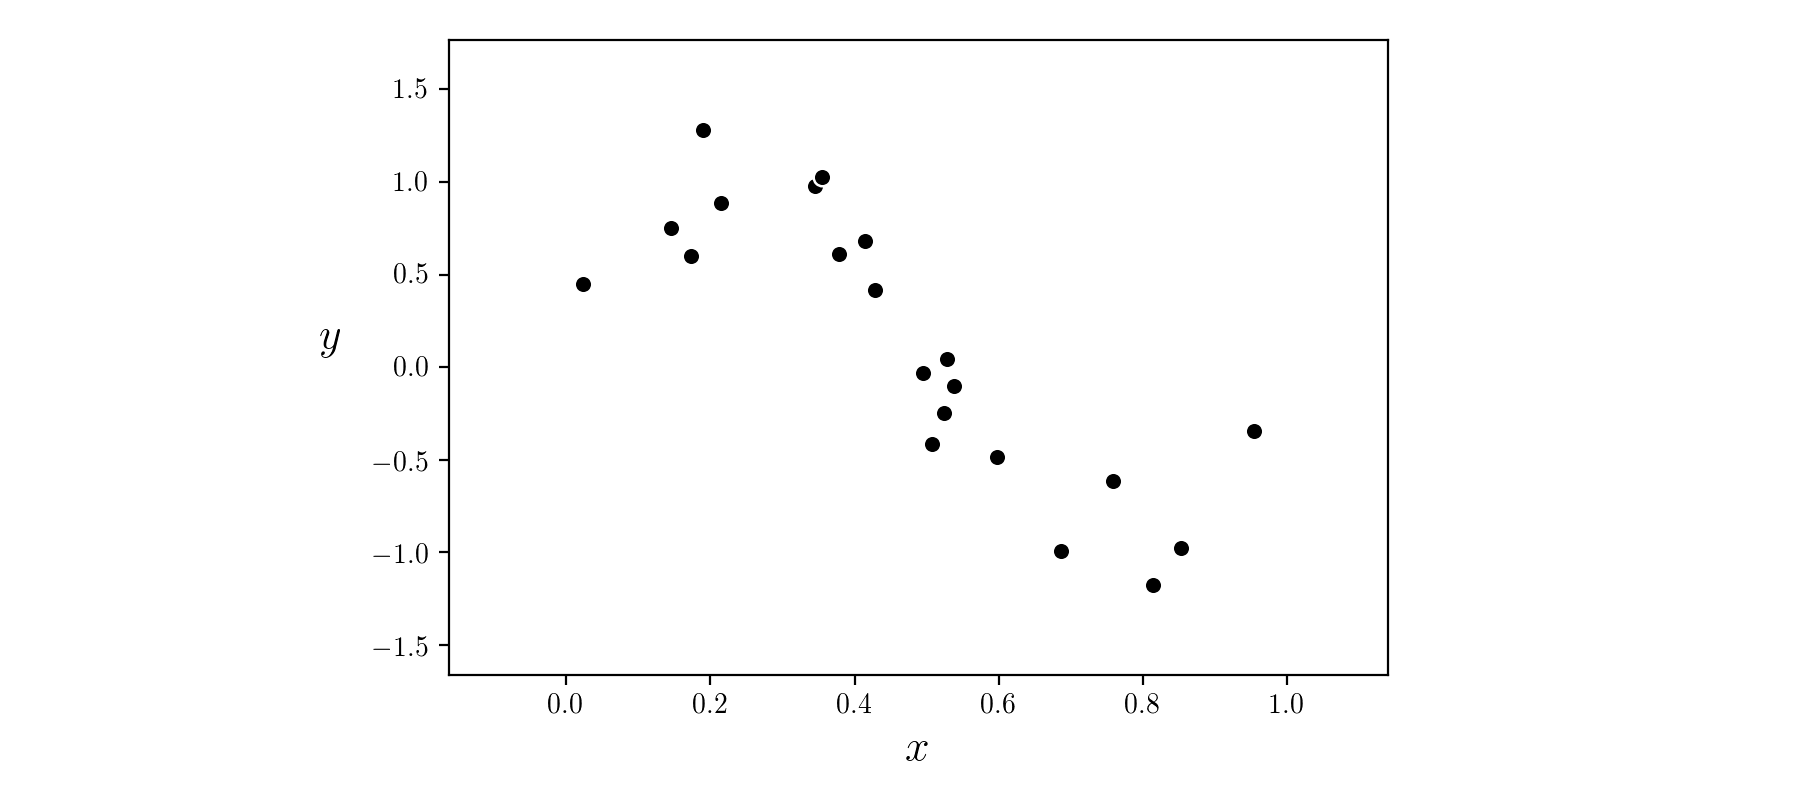

In [24]:
# load data
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:,:-1].T
y = data[:,-1:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

Here we will use a 4 layer network with 10 units in each layer.  This will certainly overfit the dataset if we tune the parameters well!

In the next Python cell we create the handle list ``layer_sizes`` for our network and generate the initial weights.

In [86]:
# An example 4 hidden layer network, with 10 units in each layer
N = 1  # dimension of input
M = 1  # dimension of output
U_1 = 10; U_2 = 10; U_3 = 10; U_4 = 10;  # number of units per hidden layer

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,U_4,M]

# generate initial weights for our network
w = initialize_network_weights(layer_sizes, scale = 0.5)

With all of our weights initialized we can then use gradient descent to tune them properly (here we used the normalized version).  Below we define our ``least_squares`` cost function and run normalized gradient descent for 5000 iterations using a fixed steplength parameter $\alpha = 10^{-1}$.

In [110]:
# run
alpha_choice = 10**(-1); max_its = 1000;
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'least_squares',normalize = 'standard')
run.fit(w=w,alpha_choice = alpha_choice,max_its=max_its)

We can then examine the cost function history to make sure gradient descent is converging properly.

<IPython.core.display.Javascript object>


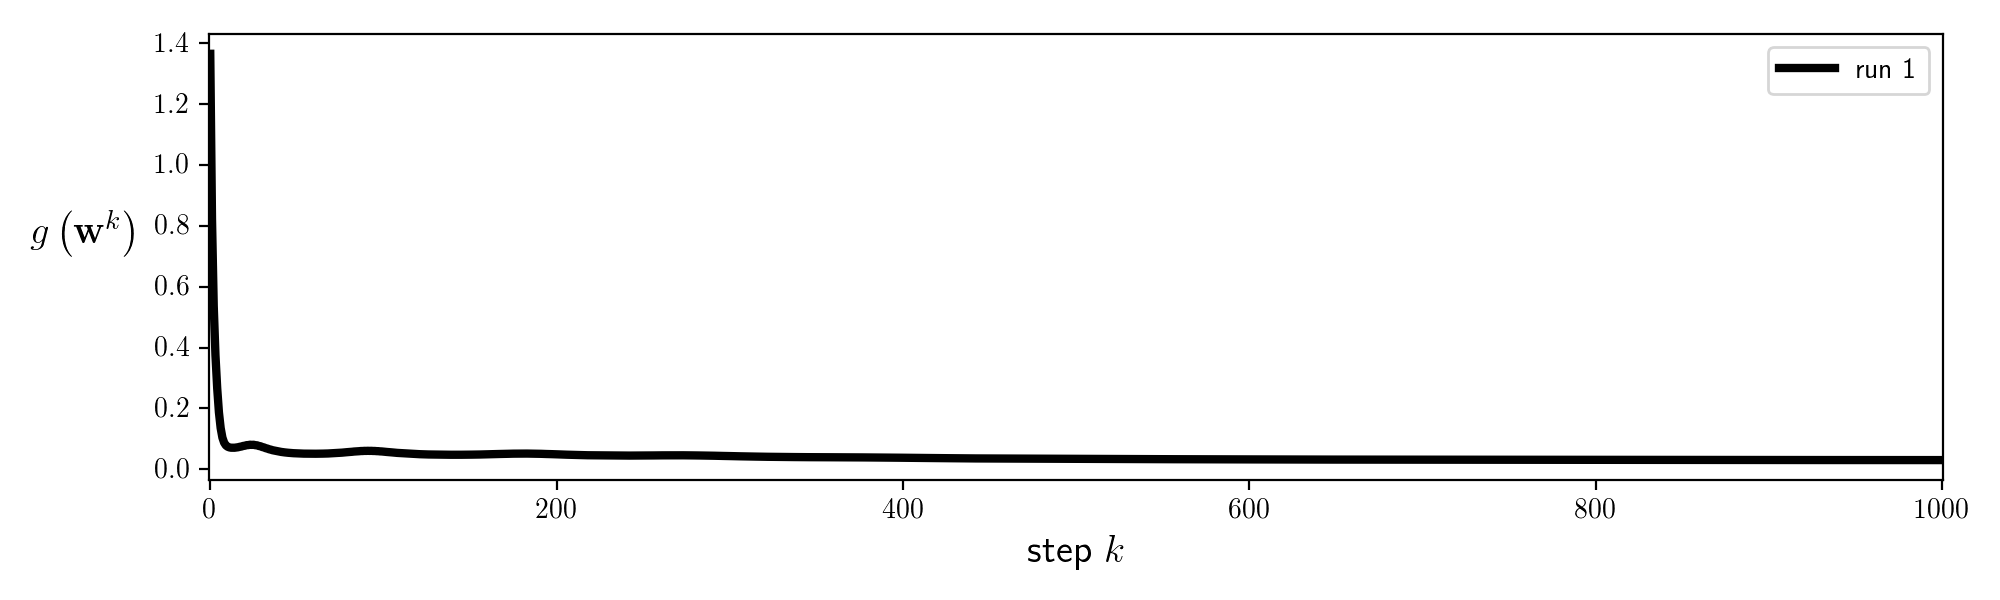

In [112]:
# plot the cost function history for a given run
static_plotter.plot_cost_histories([run.cost_history],start = 0,points = False,labels = ['run 1'])

The cost function plot looks good!  Taking the final weight from our history we can then evaluate testing points through our ``model`` function.  In particular we can illustrate our nonlinear prediction - which we do below.  We certainly do overfit, but this is not a surprise since our network is so flexible (and we optimized it quite well).

<IPython.core.display.Javascript object>


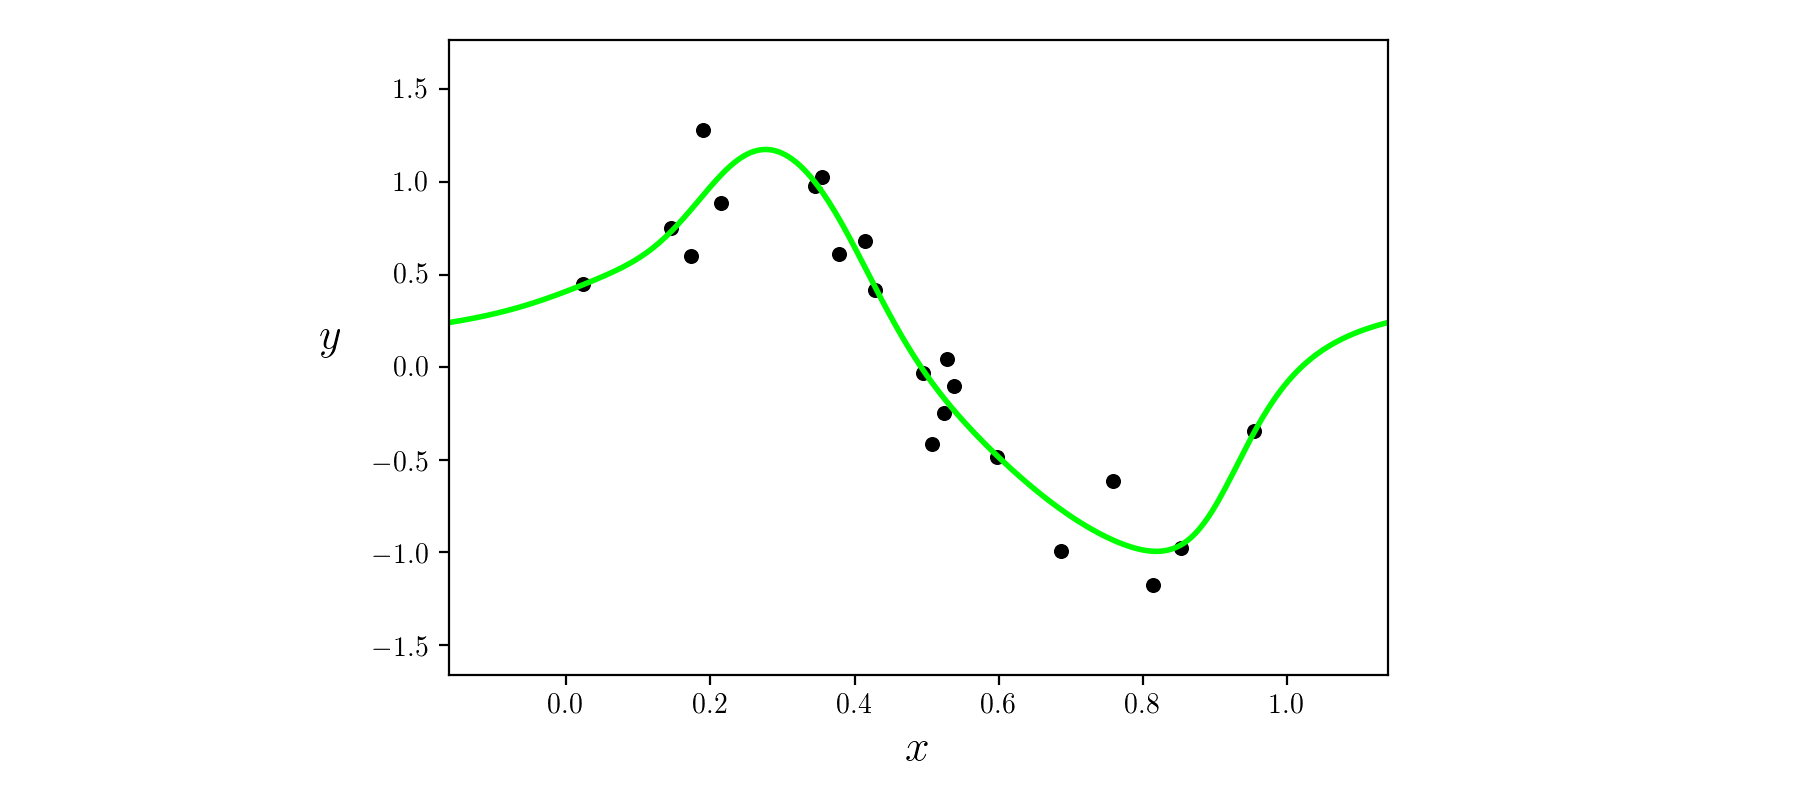

In [113]:
# pluck out best weights - those that provided lowest cost, 
# and plot resulting fit
ind = np.argmin(run.cost_history)
w_best = run.weight_history[ind]
demo.plot_fit(w_best,run.model,normalizer = run.normalizer);

#### <span style="color:#a50e3e;">Example 7. </span>  Nonlinear two-class classification example using multilayer perceptrons

Here we use a network architecture to perform nonlinear classification using the following toy dataset.  The dataset is shown 'from above' in the left panel, where red points belong to class $+1$ and blue points to class $-1$, and from the side in the right panel.

<IPython.core.display.Javascript object>


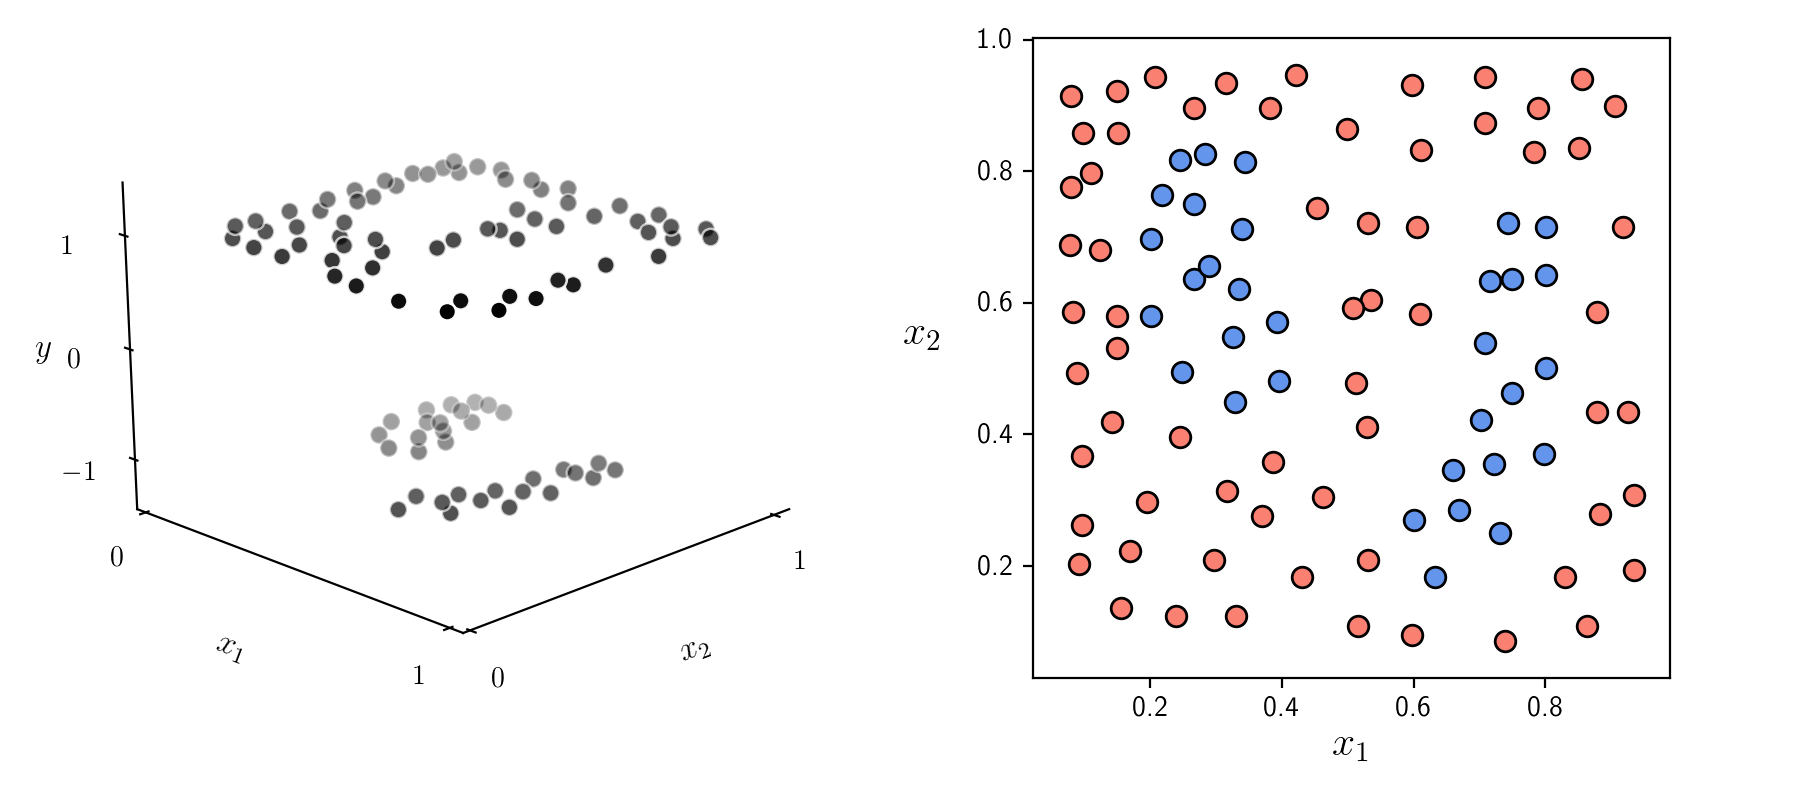

In [115]:
# create instance of linear regression demo, used below and in the next examples
demo = nonlib.nonlinear_classification_visualizer.Visualizer(datapath + '2_eggs.csv')
x = demo.x.T
y = demo.y[:,np.newaxis]

# an implementation of the least squares cost function for linear regression for N = 2 input dimension datasets
demo.plot_data();

We will use the same network architecture used in the previous regression example here - 4 hidden layers with 10 units in each layer.  Below we initialize the network, mirroring this step in the previous example.

In [146]:
# An example 4 hidden layer network, with 10 units in each layer
N = 2  # dimension of input
M = 1  # dimension of output
U_1 = 10; U_2 = 10; U_3 = 10;  # number of units per hidden layer

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,M]

# generate initial weights for our network
w = initialize_network_weights(layer_sizes, scale = 0.5)

Now we can tune the weights of our network architecture using a ``softmax`` (or logistic) cost function.  We provide a compact version of the softmax cost function below, and run normalized gradient descent for 5000 iterations using a steplength parameter $\alpha = 10^{-1}$.  

In [151]:
# parameters for our two runs of gradient descent
max_its = 1000; alpha_choice = 10**(0)

# run on normalized data
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'softmax',normalize = 'standard')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its)

With gradient descent run, we plot the cost function history at each step of gradient descent.  

<IPython.core.display.Javascript object>


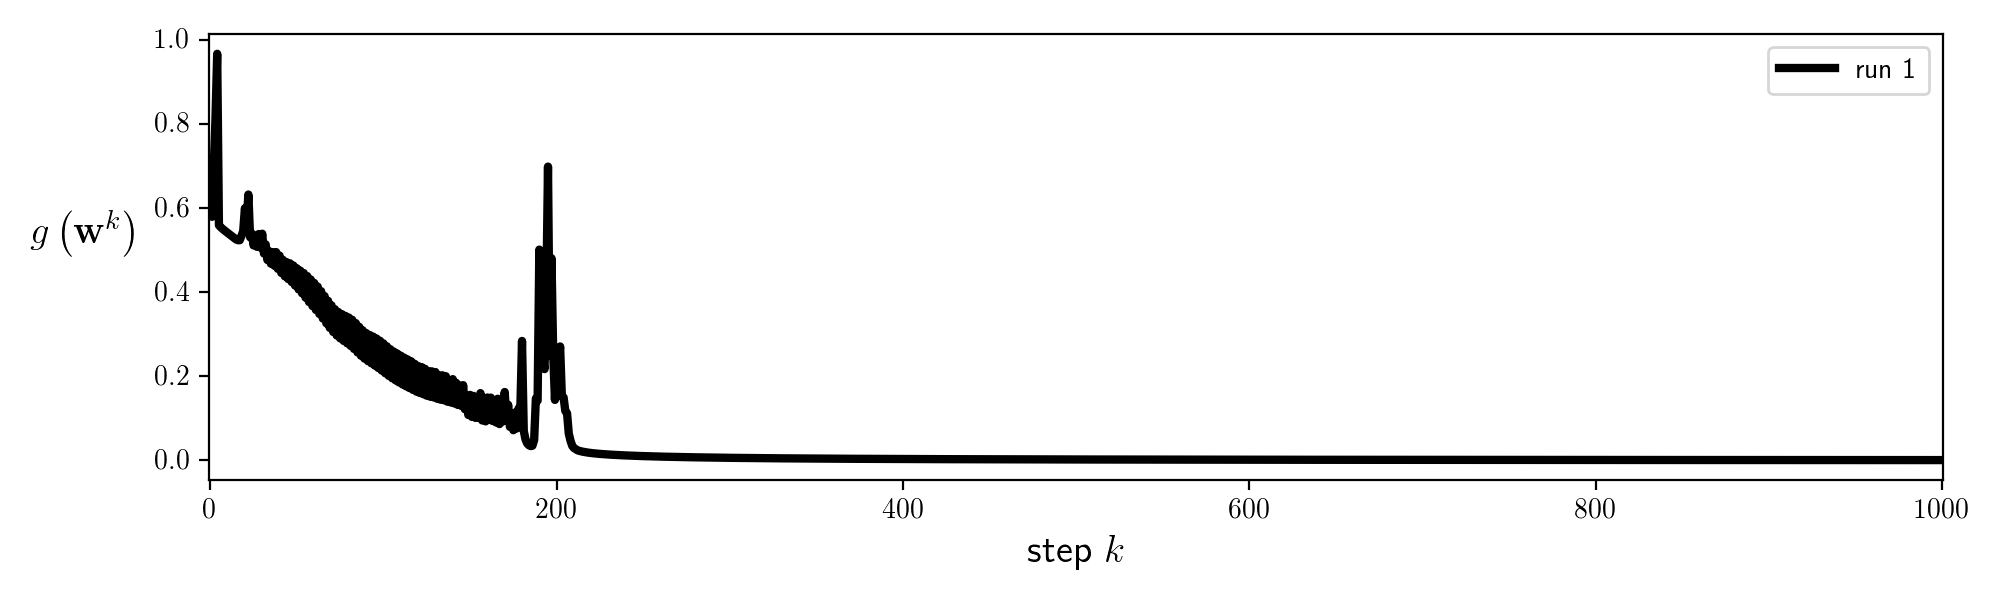

In [152]:
# plot the cost function history for a given run
static_plotter.plot_cost_histories([run.cost_history],start = 0,points = False,labels = ['run 1'])

Finally, we visualize the fit provided by the final weights learned via gradient descent.  Here it is harder to visually determine whether or not we have overfit when viewing the fit from above (in the left panel), since points from the two classes are so nicely separable by closed curves.  However when you look at the fit from the side (in the right panel) you can see how the learned surface is extremely ripply (a sign that we overkilled this particular dataset using such a flexible network).

<IPython.core.display.Javascript object>


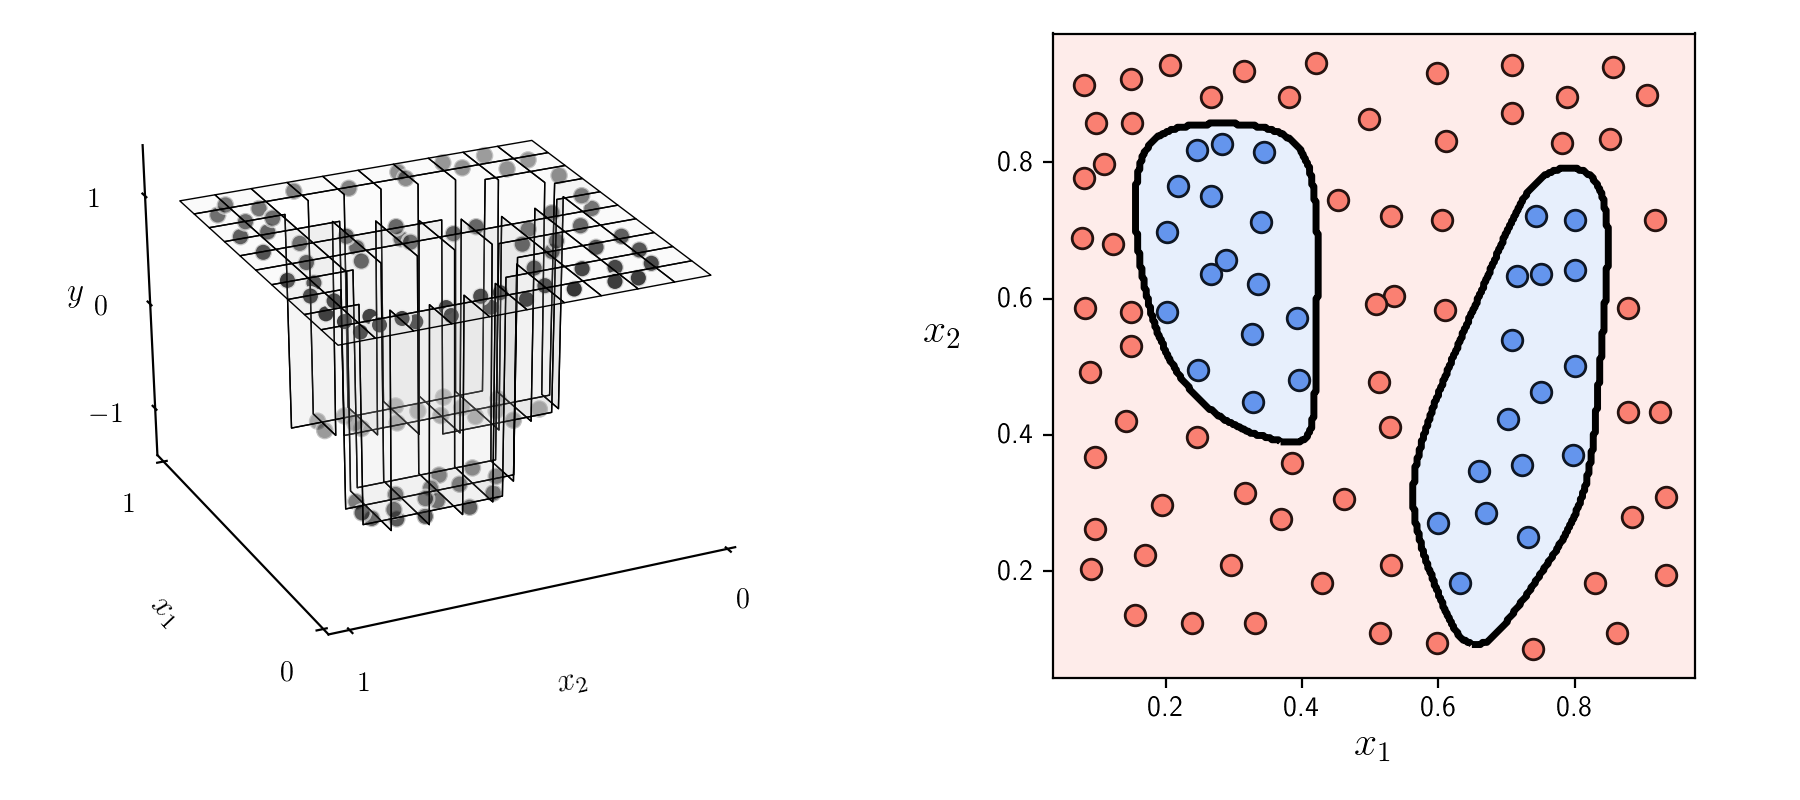

In [153]:
# illustrate results
ind = np.argmin(run.cost_history)
w_best = run.weight_history[ind]
demo.static_N2_simple(w_best,run,view = [30,155])

#### <span style="color:#a50e3e;">Example 8. </span>  Learning a nonlinear manifold using multilayer perceptron encoding/decoding functions

In this example we illustrate the use of multilayer perceptrons for both the `encoder` $f_{\text{e}}$ and `decoder` $f_{\text{d}}$ a general autoencoder function (see e.g., Section 12.3 for an introduction to the nonlinear autoencoder).  Here for both functions we will use a 3 layer multilayer perceptron with 10 units in each layer and the `tanh` activation.  We will then tune the parameters of both functions by minimizing the autoencoder cost function to uncover the proper nonlinear manifold on which the following dataset sits.

<IPython.core.display.Javascript object>


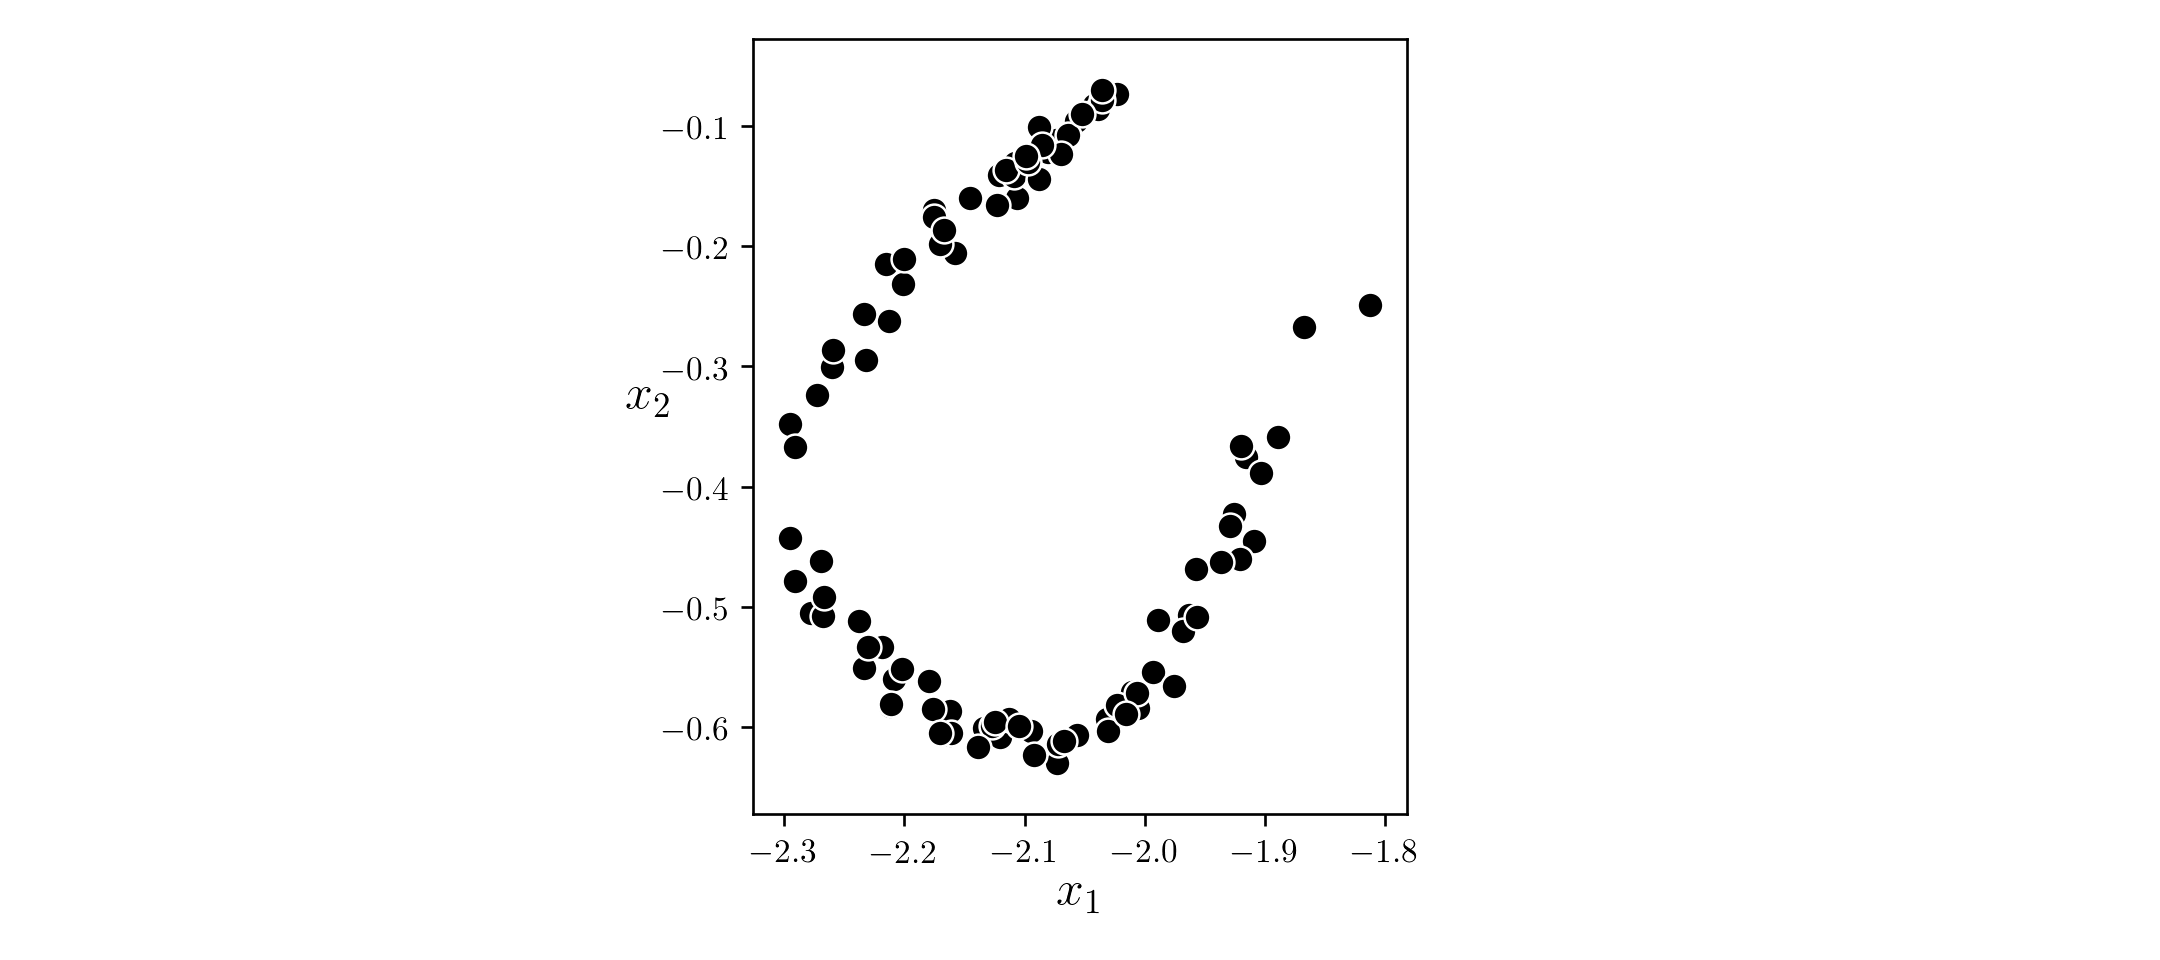

In [36]:
# import data
X = np.loadtxt(datapath + 'universal_autoencoder_samples.csv',delimiter=',')

# scatter dataset
fig = plt.figure(figsize = (9,4))
gs = gridspec.GridSpec(1,1) 
ax = plt.subplot(gs[0],aspect = 'equal'); 
ax.set_xlabel(r'$x_1$',fontsize = 15);ax.set_ylabel(r'$x_2$',fontsize = 15,rotation = 0);
ax.scatter(X[0,:],X[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w')
plt.show()

Below we initialize two multilayer perceptrons - one for each of the encoding and ecoding function.

In [42]:
### initialize encoder network ###
N = 2  # dimension of input
M = 1  # dimension of output
U_1 = 10; U_2 = 10; U_3 = 10;  # number of units per hidden layer

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,M]

# generate initial weights for our network
w_encoder = initialize_network_weights(layer_sizes, scale = 0.5)

### initialize decoder network ###
N = 1  # dimension of input
M = 2  # dimension of output

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,M]

# generate initial weights for our network
w_decoder = initialize_network_weights(layer_sizes, scale = 0.5)

# gather initializations for both encoder and encoder, package into single list
w = [w_encoder,w_decoder]

With our encoder and decoder constructed and initialized, we then minimize the corresponding autoencoder cost function over the dataset.

<IPython.core.display.Javascript object>


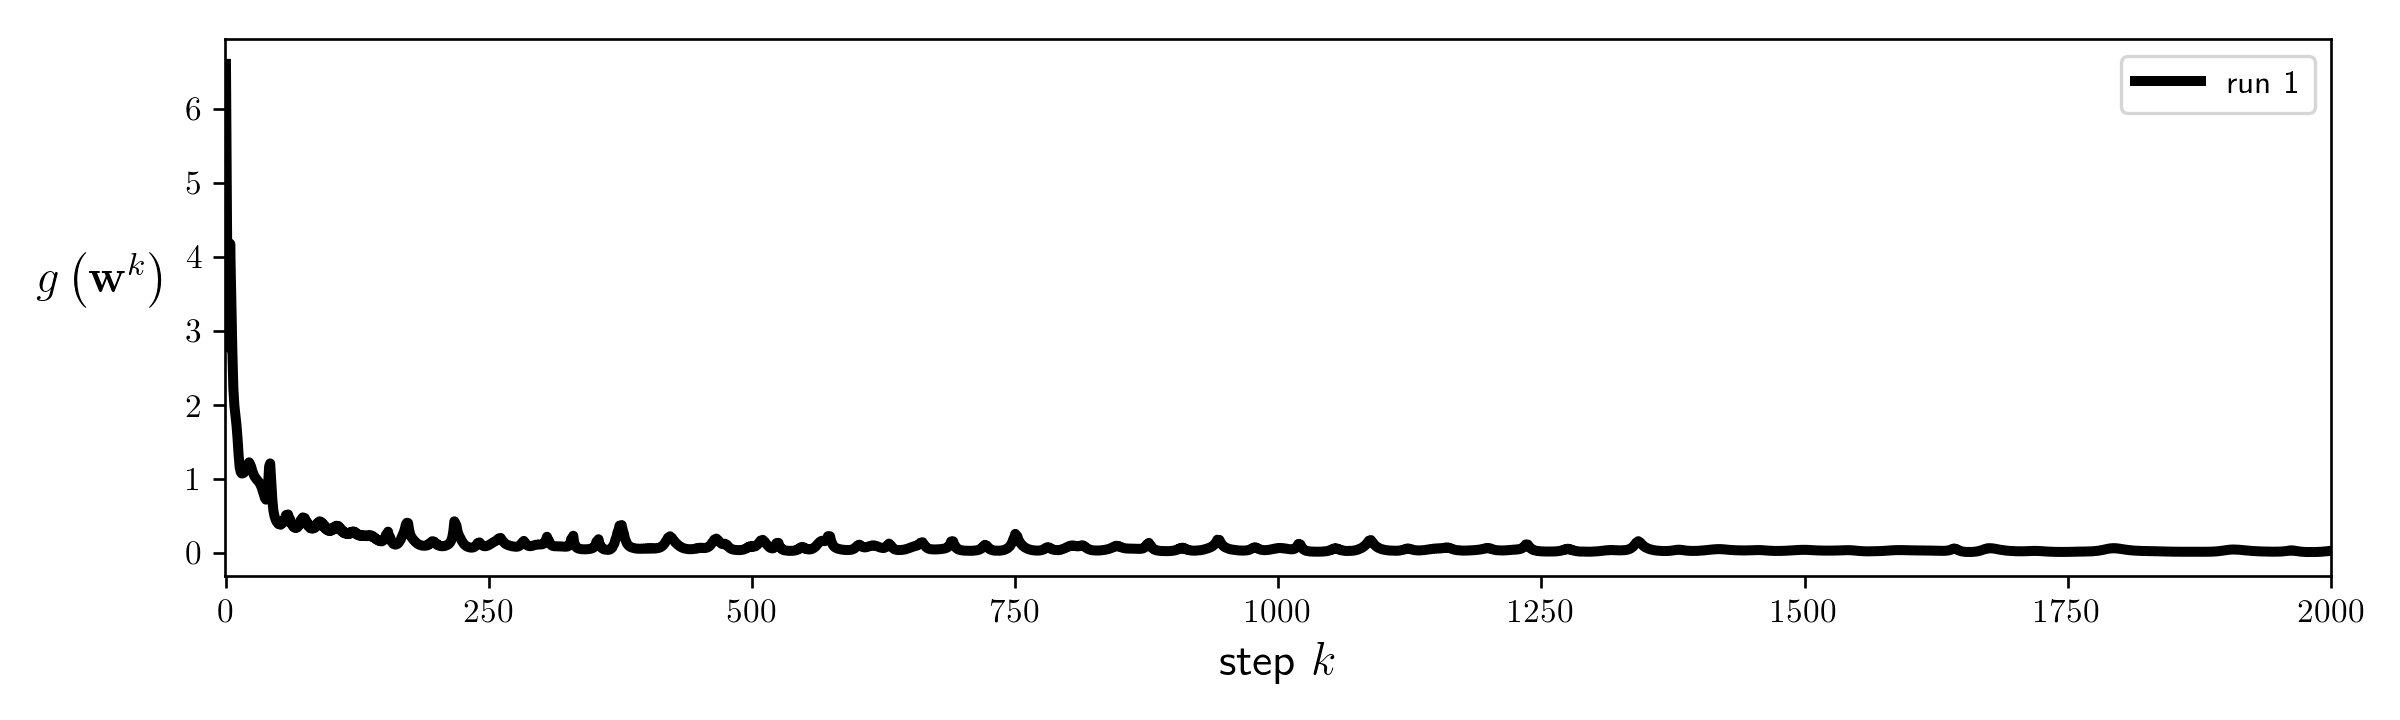

In [43]:
# parameters for our two runs of gradient descent
max_its = 2000; alpha_choice = 10**(-1)

# run on normalized data
run = nonlib.basic_runner.Setup(X,[],feature_transforms,'autoencoder',normalize = 'standard',feature_transforms_2 = feature_transforms)
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its)

# plot the cost function history for a given run
static_plotter.plot_cost_histories([run.cost_history],start = 0,points = False,labels = ['run 1'])

Having minimized the cost function appropriately we can now visualize the learned manifold (middle panel below) and the decoded version of the original dataset (right panel below) - i.e., the original dataset projected onto our learned manifold.  We can also visualize how all of the data in this space is projected onto the learned manifold via a vector field plot, which we do in the bottom panel.

<IPython.core.display.Javascript object>


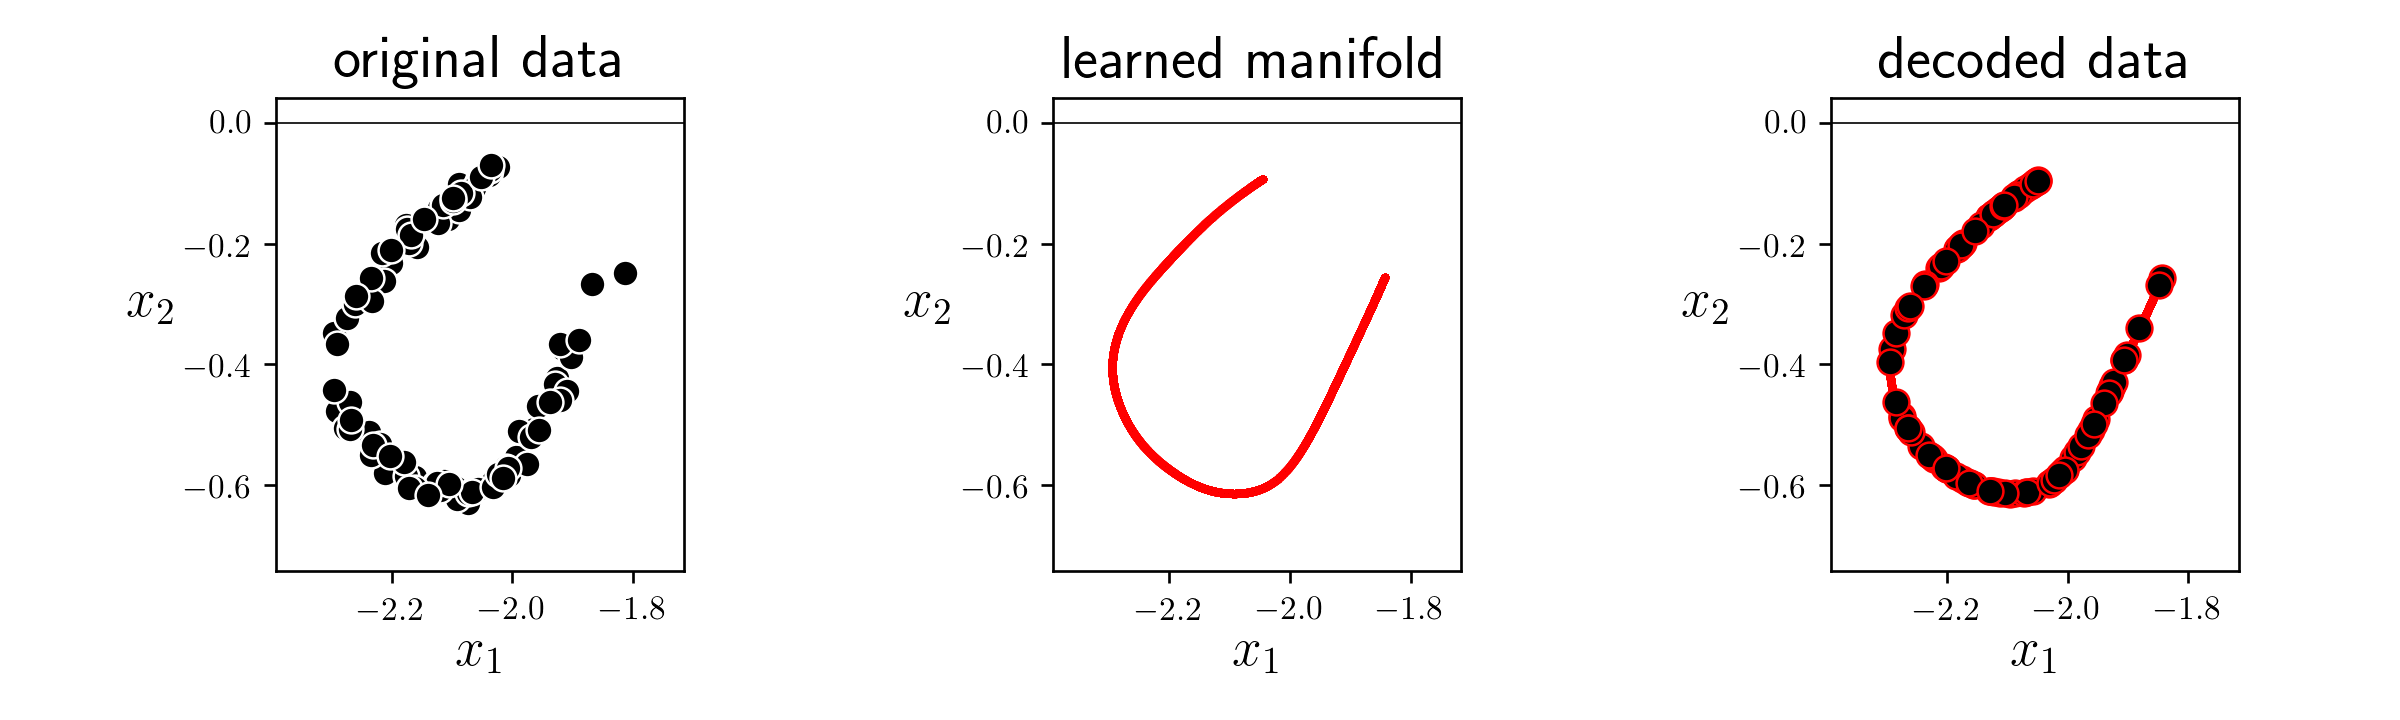

<IPython.core.display.Javascript object>


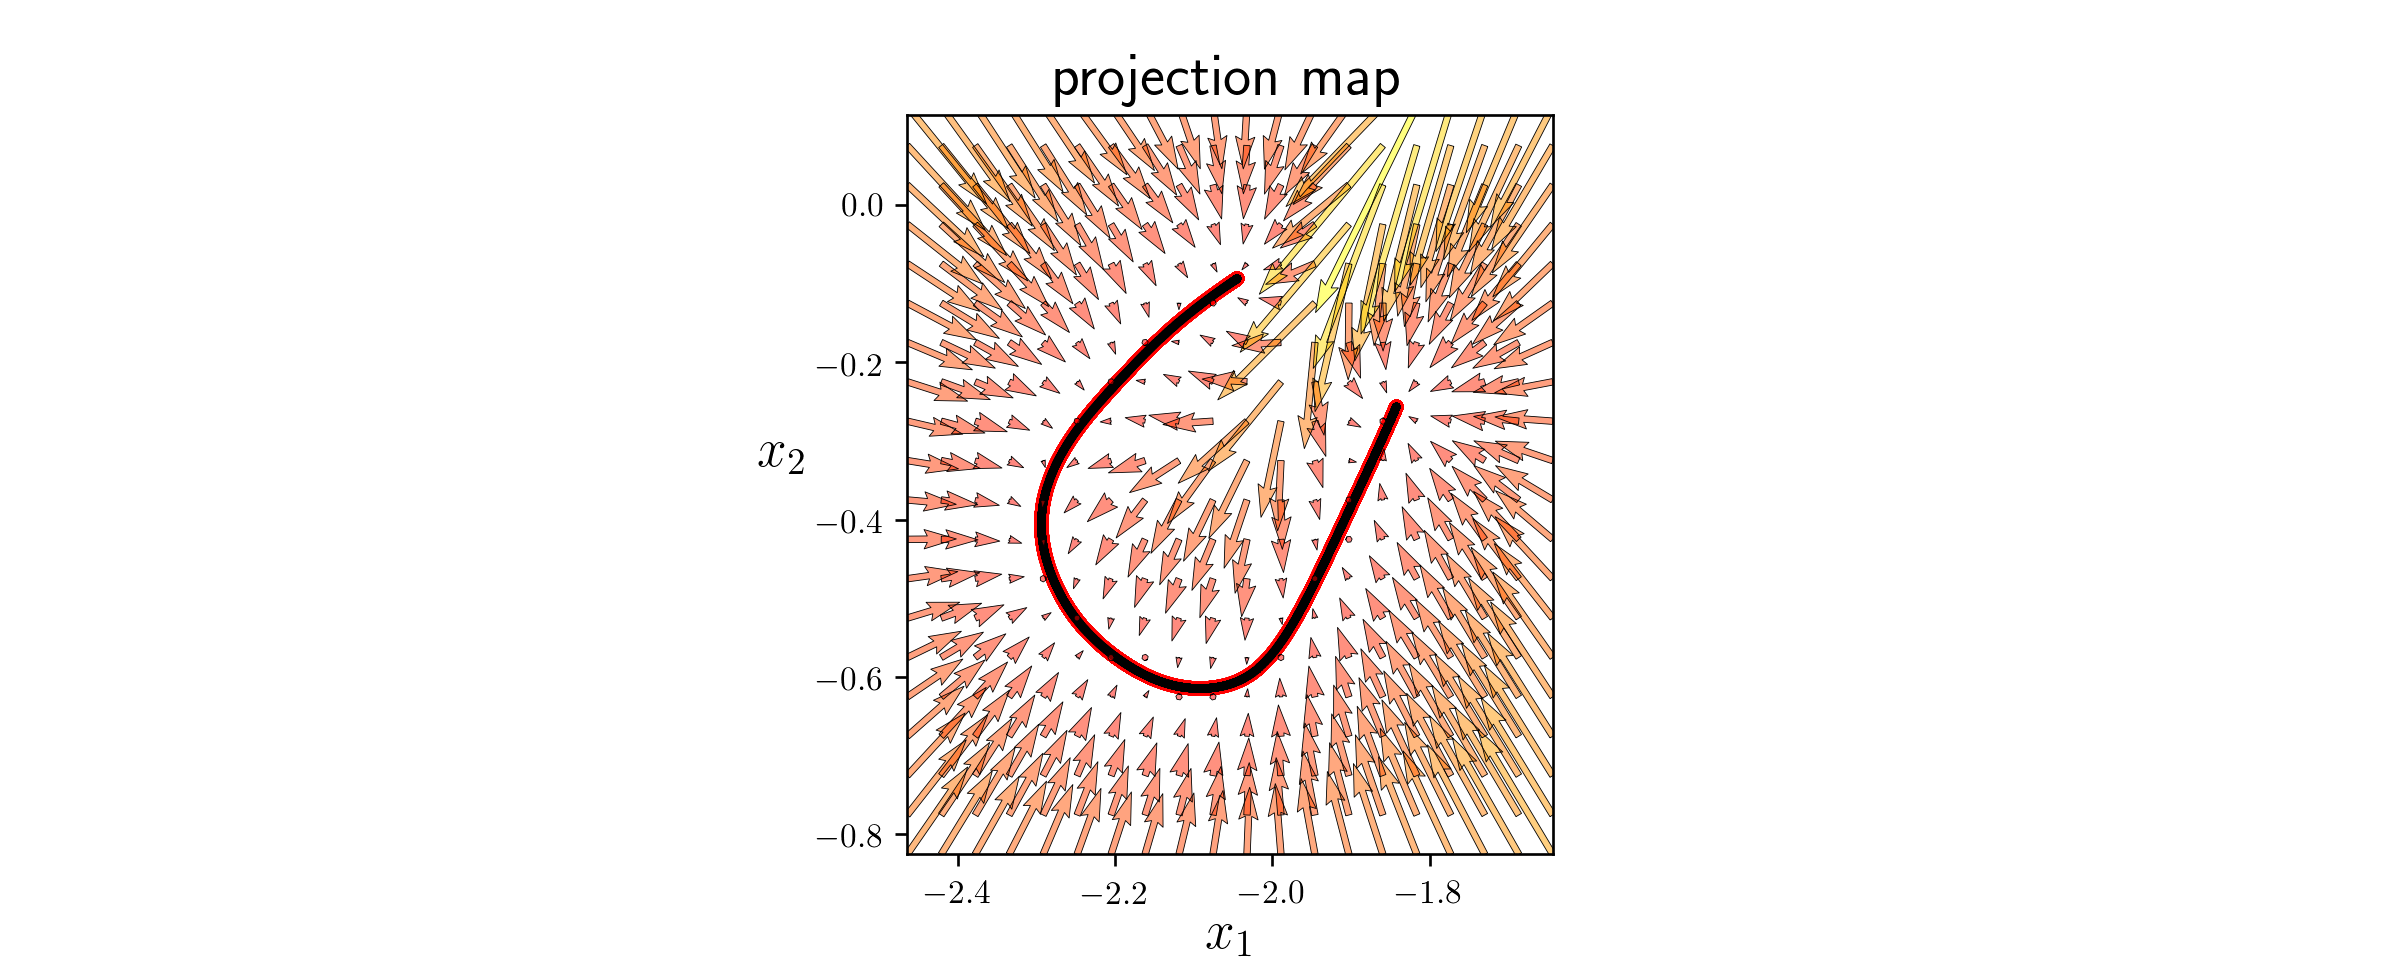

In [51]:
# plot results
nonlib.autoencoder_demos.show_encode_decode(X,run,projmap = True,scale = 4.5)

<a id='bib_cell'></a>

## References

[1]  W. S. McCulloch and W. Pitts. A logical calculus of the ideas immanent in nervous activity. The bulletin of mathematical biophysics, 5(4):115–133, 1943.

[2]  D. O. Hebb. The organization of behavior: a neuropsychological theory. John Wiley & Sons, New York, 1949.

[3]  F. Rosenblatt. The perceptron - a perceiving and recognizing automaton. Cornell Aeronautical Laboratory, 1957.